In [2]:
#importing necessary libraries

import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import numpy as np
from sklearn import preprocessing

# Part 1: Ingest + Clean
Working with API keys and different data sources, I will analyze historical Seattle crime data and gain insights for the different districts within the city. I will start with basic EDA and visualize general findings to help define the questions for part 2.


- Data was said to be updated every 24 hrs but when inspecting it I noticed the last row was from Feb 2020, based on this I decided to focus my analysis on pre-pandemic years and chose to go back a decade instead. 

In [3]:
#importing api key to data from: https://data.seattle.gov/
api_key = open('Seattle-crime-data-API-key.txt', 'r').read()

#setting parameters
#default limit was 1,000 rows, I decided to change it to 500,000 to go far back enough to grab data a few years
#prior to 2013. I will conduct my analysis for the span of a decade (2009-2019) pre-pandemic. 
limit = 500000
offset = 0

#requesting api
response = requests.get(api_key, params = {'$limit': limit, '$offset': offset})
#ensuring call was successful
print(response.status_code)

200


In [4]:
#code commented out but written to ensure HTML loaded correctly
#print(response.json())

In [4]:
#writing the response to a json file first
with open('response.json', 'w') as f:
    f.write(response.text)

#turning the json file to a df
seattle_crime_df = pd.read_json('response.json')

### Quick Data inspection for seattle_crime_df

In [5]:
seattle_crime_df.head()

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime
0,2020-044620,12605873663,2020-02-05T10:10:00.000,2020-02-05T11:24:31.000,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,W,Q,Q1,MAGNOLIA,32XX BLOCK OF 23RD AVE W,-122.385974,47.649387,NaN
1,2020-044452,12605598696,2020-02-03T08:00:00.000,2020-02-05T10:06:28.000,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,N,J,J3,ROOSEVELT/RAVENNA,63XX BLOCK OF 5TH AVE NE,-122.323399,47.675118,2020-02-04T08:00:00.000
2,2020-044465,12605567653,2020-02-02T20:30:00.000,2020-02-05T09:39:33.000,A,PROPERTY,ROBBERY,Robbery,120,N,U,U3,ROOSEVELT/RAVENNA,26TH AVE NE / NE BLAKELEY ST,-122.299552,47.666384,2020-02-02T21:30:00.000
3,2020-044225,12605174036,2020-02-05T01:17:00.000,2020-02-05T03:30:55.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,Q,Q1,MAGNOLIA,22XX BLOCK OF W RAYE ST,-122.384865,47.642927,2020-02-05T02:21:00.000
4,2020-044076,12605081469,2020-02-05T00:51:21.000,2020-02-05T00:51:31.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,B,B2,BALLARD SOUTH,NW 46TH ST / 8TH AVE NW,-122.366195,47.662193,NaN


In [6]:
seattle_crime_df.tail()

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime
499995,2008-449398,7628700115,2008-12-01T13:00:00.000,2008-12-01T22:12:00.000,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,S,R,R2,CLAREMONT/RAINIER VISTA,44XX BLOCK OF LETITIA AVE S,-122.289183,47.563461,2008-12-01T22:00:00.000
499996,2008-449384,7678097431,2008-12-01T18:30:00.000,2008-12-01T22:02:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,S,S3,RAINIER VIEW,103XX BLOCK OF 61ST AVE S,-122.257857,47.508117,NaN
499997,2008-449340,7649625645,2008-12-01T19:30:00.000,2008-12-01T21:05:00.000,A,PERSON,SEX OFFENSES,Fondling,11D,E,E,E2,CAPITOL HILL,NaN,0.000000,0.000000,NaN
499998,2008-449253,7675902414,2008-12-01T19:44:00.000,2008-12-01T20:57:00.000,A,PROPERTY,ROBBERY,Robbery,120,W,D,D3,SLU/CASCADE,MINOR AVE / STEWART ST,-122.331859,47.617610,NaN
499999,2008-449330,7700123585,2008-11-01T06:00:00.000,2008-12-01T20:45:00.000,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,S,R,R1,MID BEACON HILL,12XX BLOCK OF S SNOQUALMIE ST,-122.316461,47.561696,2008-12-01T20:00:00.000


In [7]:
seattle_crime_df.shape

(500000, 17)

In [8]:
seattle_crime_df.dtypes

report_number              object
offense_id                  int64
offense_start_datetime     object
report_datetime            object
group_a_b                  object
crime_against_category     object
offense_parent_group       object
offense                    object
offense_code               object
precinct                   object
sector                     object
beat                       object
mcpp                       object
_100_block_address         object
longitude                 float64
latitude                  float64
offense_end_datetime       object
dtype: object

In [9]:
seattle_crime_df.isnull().any()

report_number             False
offense_id                False
offense_start_datetime    False
report_datetime           False
group_a_b                 False
crime_against_category    False
offense_parent_group      False
offense                   False
offense_code              False
precinct                  False
sector                    False
beat                      False
mcpp                      False
_100_block_address         True
longitude                 False
latitude                  False
offense_end_datetime       True
dtype: bool

In [10]:
seattle_crime_df.columns

Index(['report_number', 'offense_id', 'offense_start_datetime',
       'report_datetime', 'group_a_b', 'crime_against_category',
       'offense_parent_group', 'offense', 'offense_code', 'precinct', 'sector',
       'beat', 'mcpp', '_100_block_address', 'longitude', 'latitude',
       'offense_end_datetime'],
      dtype='object')

In [11]:
seattle_crime_df.describe()

,offense_id,longitude,latitude
count,5.000000e+05,500000.000000,500000.000000
mean,7.814139e+09,-118.100649,45.973751
std,6.999023e+08,22.356896,8.703152
min,7.624429e+09,-122.430904,0.000000
25%,7.647802e+09,-122.348746,47.583848
50%,7.670991e+09,-122.331934,47.614076
75%,7.689468e+09,-122.313261,47.662181
max,1.260587e+10,0.000000,47.774843


In [12]:
seattle_crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   report_number           500000 non-null  object 
 1   offense_id              500000 non-null  int64  
 2   offense_start_datetime  500000 non-null  object 
 3   report_datetime         500000 non-null  object 
 4   group_a_b               500000 non-null  object 
 5   crime_against_category  500000 non-null  object 
 6   offense_parent_group    500000 non-null  object 
 7   offense                 500000 non-null  object 
 8   offense_code            500000 non-null  object 
 9   precinct                500000 non-null  object 
 10  sector                  500000 non-null  object 
 11  beat                    500000 non-null  object 
 12  mcpp                    500000 non-null  object 
 13  _100_block_address      482702 non-null  object 
 14  longitude           

#### Quick conclusions
The data is fairly well recorded, it seems there is only 2 columns that have null values: _100_block_address, offense_end_datetime. Since the latitude and longitude and neighboorhoods are included in the mcpp (micro-community policing plans) column, that doesn't seem to have null values I can use that information instead of the 100 block address. 
Some items I can explore is which MCPP's experience the most number of reports (after selecting years of focus) and analyze if their response times vary and whether this has any influence over the number of incidents. 
Maybe I could map poverty levels to the crime data (only looking at year 2022 since that's where the other data comes from and is static)

In [13]:
#making a copy of the df for manipulation
crime_data = seattle_crime_df.copy()

#grabbing only the year the reports were made
crime_data['offense_year'] = crime_data['offense_start_datetime'].str.slice(stop=4)

#grouping the number of incidents reported by year
crime_data_year_counts = crime_data.groupby('offense_year').size().reset_index(name = 'incidents_reported_by_year')
crime_data_year_counts

,offense_year,incidents_reported_by_year
0,1908,1
1,1964,1
2,1977,1
3,1980,1
4,1987,1
5,1990,1
6,1991,12
7,1992,2
8,1993,2
9,1994,3


In [14]:
#code to find when the last observation was made in 2020 to decide whether to consider these reports
last_year_observation = crime_data.loc[crime_data['offense_year'] == '2020', 'offense_start_datetime'].max()
last_year_observation

'2020-02-05T10:10:00.000'

From the finding above, one can explain the significant decrease in incidents reported from 2019-2020 to a lack of robust observations since the last one made was in february of 2020. I will examine the records from 2009-2019.

In [15]:
#focusing on decade 2009-2019 & sorting the values so they're displayed from 2009-onward
crime_2009_2019 = crime_data.loc[(crime_data['offense_year'] >= '2009') & (crime_data['offense_year'] <= '2019')].sort_values(by = 'offense_year')
crime_2009_2019.head()

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year
496595,2009-000121,7666812233,2009-01-01T00:57:00.000,2009-01-01T00:57:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,U,U3,SANDPOINT,NE 86TH ST / 35TH AVE NE,-122.290695,47.690926,NaN,2009
465119,2009-320117,7641423230,2009-09-10T01:00:00.000,2009-09-10T07:08:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,R,R1,MID BEACON HILL,14XX BLOCK OF S FERDINAND ST,-122.313796,47.559048,2009-09-10T07:00:00.000,2009
465118,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,D,D3,SLU/CASCADE,9XX BLOCK OF FAIRVIEW AVE N,-122.332465,47.627483,2009-09-09T20:15:00.000,2009
465117,2009-320142,7651616695,2009-09-09T15:00:00.000,2009-09-10T07:40:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,E,E,E2,CAPITOL HILL,17XX BLOCK OF BROADWAY,-122.320826,47.616987,2009-09-10T07:30:00.000,2009
465116,2009-320146,7692993127,2009-09-10T07:47:00.000,2009-09-10T07:47:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,Q,Q2,QUEEN ANNE,7TH AVE W / W HIGHLAND DR,-122.366472,47.629608,NaN,2009


In [16]:
#dropping the offense end times and 100th block address columns since they won't be relevant to my analysis
crime_2009_2019.drop(columns = ['offense_end_datetime', '_100_block_address'])

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,longitude,latitude,offense_year
496595,2009-000121,7666812233,2009-01-01T00:57:00.000,2009-01-01T00:57:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,U,U3,SANDPOINT,-122.290695,47.690926,2009
465119,2009-320117,7641423230,2009-09-10T01:00:00.000,2009-09-10T07:08:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,R,R1,MID BEACON HILL,-122.313796,47.559048,2009
465118,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,D,D3,SLU/CASCADE,-122.332465,47.627483,2009
465117,2009-320142,7651616695,2009-09-09T15:00:00.000,2009-09-10T07:40:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,E,E,E2,CAPITOL HILL,-122.320826,47.616987,2009
465116,2009-320146,7692993127,2009-09-10T07:47:00.000,2009-09-10T07:47:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,Q,Q2,QUEEN ANNE,-122.366472,47.629608,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28498,2019-146649,8195231074,2019-04-25T12:07:00.000,2019-04-25T12:52:00.000,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,N,L,L2,NORTHGATE,-122.317862,47.709175,2019
28497,2019-146660,8195210640,2019-04-25T12:58:00.000,2019-04-25T12:59:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,D,D1,BELLTOWN,-122.347496,47.616302,2019
28496,2019-904572,8195276268,2019-04-25T10:50:00.000,2019-04-25T13:06:00.000,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,SW,F,F1,HIGH POINT,-122.362975,47.552820,2019
28494,2019-904578,8195200525,2019-04-22T02:00:00.000,2019-04-25T13:22:00.000,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,N,B,B3,WALLINGFORD,-122.329071,47.663801,2019


In [17]:
#finding the unique mcpp categories used and storing it in an array
unique_mcpp = crime_2009_2019['mcpp'].unique()
unique_mcpp

array(['SANDPOINT', 'MID BEACON HILL', 'SLU/CASCADE', 'CAPITOL HILL',
       'QUEEN ANNE', 'JUDKINS PARK/NORTH BEACON HILL', 'MORGAN',
       'FREMONT', 'CHINATOWN/INTERNATIONAL DISTRICT', 'BELLTOWN',
       'HIGHLAND PARK', 'GREENWOOD', 'MADRONA/LESCHI',
       'DOWNTOWN COMMERCIAL', 'MAGNOLIA', 'ROOSEVELT/RAVENNA',
       'ROXHILL/WESTWOOD/ARBOR HEIGHTS', 'WALLINGFORD', 'ALKI',
       'HILLMAN CITY', 'MOUNT BAKER', 'FIRST HILL', 'BALLARD SOUTH',
       'SOUTH PARK', 'UNIVERSITY', 'EASTLAKE - EAST', 'MILLER PARK',
       'GEORGETOWN', 'CLAREMONT/RAINIER VISTA', 'NORTH ADMIRAL',
       'PHINNEY RIDGE', 'ALASKA JUNCTION', 'HIGH POINT', 'SODO',
       'NORTHGATE', 'PIONEER SQUARE', 'CENTRAL AREA/SQUIRE PARK',
       'NORTH BEACON HILL', 'RAINIER VIEW', 'BALLARD NORTH',
       'RAINIER BEACH', 'BRIGHTON/DUNLAP', 'UNKNOWN', 'MADISON PARK',
       'COLUMBIA CITY', 'MONTLAKE/PORTAGE BAY', 'BITTERLAKE',
       'SOUTH DELRIDGE', 'GENESEE', 'NORTH DELRIDGE', 'SOUTH BEACON HILL',
       'EASTLAK

In [18]:
#found an 'unknown' value in the mcpp column, locating this row to determine impact
crime_2009_2019.loc[crime_2009_2019['mcpp'] == 'unkown']

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year


In [19]:
#converting array to list and removing the 'UNKOWN' mcpp since it didn't contain any data
mcpp_list = unique_mcpp.tolist()
mcpp_list.remove('UNKNOWN')

mcpp_list

['SANDPOINT',
 'MID BEACON HILL',
 'SLU/CASCADE',
 'CAPITOL HILL',
 'QUEEN ANNE',
 'JUDKINS PARK/NORTH BEACON HILL',
 'MORGAN',
 'FREMONT',
 'CHINATOWN/INTERNATIONAL DISTRICT',
 'BELLTOWN',
 'HIGHLAND PARK',
 'GREENWOOD',
 'MADRONA/LESCHI',
 'DOWNTOWN COMMERCIAL',
 'MAGNOLIA',
 'ROOSEVELT/RAVENNA',
 'ROXHILL/WESTWOOD/ARBOR HEIGHTS',
 'WALLINGFORD',
 'ALKI',
 'HILLMAN CITY',
 'MOUNT BAKER',
 'FIRST HILL',
 'BALLARD SOUTH',
 'SOUTH PARK',
 'UNIVERSITY',
 'EASTLAKE - EAST',
 'MILLER PARK',
 'GEORGETOWN',
 'CLAREMONT/RAINIER VISTA',
 'NORTH ADMIRAL',
 'PHINNEY RIDGE',
 'ALASKA JUNCTION',
 'HIGH POINT',
 'SODO',
 'NORTHGATE',
 'PIONEER SQUARE',
 'CENTRAL AREA/SQUIRE PARK',
 'NORTH BEACON HILL',
 'RAINIER VIEW',
 'BALLARD NORTH',
 'RAINIER BEACH',
 'BRIGHTON/DUNLAP',
 'MADISON PARK',
 'COLUMBIA CITY',
 'MONTLAKE/PORTAGE BAY',
 'BITTERLAKE',
 'SOUTH DELRIDGE',
 'GENESEE',
 'NORTH DELRIDGE',
 'SOUTH BEACON HILL',
 'EASTLAKE - WEST',
 'FAUNTLEROY SW',
 'LAKEWOOD/SEWARD PARK',
 'NEW HOLLY',
 'PI

In [20]:
#importing new df to help map mcpp values to a neighborhood and then a district
seattle_districts = pd.read_csv('Neighborhood_Map_Atlas_Neighborhoods.csv')
seattle_districts

,OBJECTID,L_HOOD,S_HOOD,S_HOOD_ALT_NAMES,Shape__Area,Shape__Length
0,27,Ballard,Loyal Heights,NaN,2.132066e+07,18831.009596
1,28,Ballard,Ballard,Adams,2.255213e+07,29926.339300
2,29,Ballard,Whittier Heights,NaN,1.419569e+07,15934.439266
3,30,Ballard,West Woodland,NaN,2.219937e+07,21789.651087
4,31,North Central,Phinney Ridge,Woodland Park,3.212312e+07,27120.785938
...,...,...,...,...,...,...
89,119,Ballard,Sunset Hill,"Golden Gardens, Shilshole",2.433562e+07,29416.730063
90,121,University District,University District,NaN,1.368625e+07,21581.645979
91,123,University District,University Heights,Cowen Park,1.037575e+07,15163.906910
92,124,Downtown,Denny Triangle,Denny Regrade,5.128172e+06,10574.177983


In [21]:
#turning the string values in the seattle_districts df to upper case for mapping
seattle_districts['L_HOOD'] = seattle_districts['L_HOOD'].str.upper()
seattle_districts['S_HOOD'] = seattle_districts['S_HOOD'].str.upper()
seattle_districts['S_HOOD_ALT_NAMES'] = seattle_districts['S_HOOD_ALT_NAMES'].str.upper()
seattle_districts.head()

,OBJECTID,L_HOOD,S_HOOD,S_HOOD_ALT_NAMES,Shape__Area,Shape__Length
0,27,BALLARD,LOYAL HEIGHTS,NaN,2.132066e+07,18831.009596
1,28,BALLARD,BALLARD,ADAMS,2.255213e+07,29926.339300
2,29,BALLARD,WHITTIER HEIGHTS,NaN,1.419569e+07,15934.439266
3,30,BALLARD,WEST WOODLAND,NaN,2.219937e+07,21789.651087
4,31,NORTH CENTRAL,PHINNEY RIDGE,WOODLAND PARK,3.212312e+07,27120.785938


In [22]:
#finding the unique neighborhoods in the s_hood column
neighborhood_districts_array = seattle_districts['S_HOOD'].unique()
#sorting values so they're kept in lower case
neighborhood_districts_list = sorted(neighborhood_districts_array)
len(neighborhood_districts_list)

#finding unique values in the alternate names
alt_names= seattle_districts['S_HOOD_ALT_NAMES'].unique()
#storing these in a list
alt_names_list = alt_names.tolist()
alt_names_list
#creating a series to get the nan value out
alt_names_series = pd.Series(alt_names_list)
#turning the series back to a list after cleaning the nan value
alt_names_clean = alt_names_series[alt_names_series.notna()].tolist()
alt_names_clean

#adding the alternate names to the list i want to work with
neighborhood_districts_list.extend(alt_names_clean)

#confirming the addition of the values
len(neighborhood_districts_list)

132

#### note:
Naming conventions in crime DF and the seattle_districts DF differ, importing fuzzywuzzy to find best matches

In [23]:
!pip install fuzzywuzzy
from fuzzywuzzy import process
!pip install python-Levenshtein

#### the code right below may be a little slow!

In [24]:
#creating a series with the best match for each 'mcpp'
matches = crime_2009_2019['mcpp'].apply(lambda x: process.extractOne(x, neighborhood_districts_list))

#extracting the best match and creating a new column for it
crime_2009_2019['mapped_mcpp_neighborhood'] = matches.apply(lambda x: x[0])

#adding a match score to confirm all neighborhoods are correctly mapped
crime_2009_2019['match_score'] = matches.apply(lambda x: x[1])

crime_2009_2019.head()

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score
496595,2009-000121,7666812233,2009-01-01T00:57:00.000,2009-01-01T00:57:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,U,U3,SANDPOINT,NE 86TH ST / 35TH AVE NE,-122.290695,47.690926,NaN,2009,SAND POINT,95
465119,2009-320117,7641423230,2009-09-10T01:00:00.000,2009-09-10T07:08:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,R,R1,MID BEACON HILL,14XX BLOCK OF S FERDINAND ST,-122.313796,47.559048,2009-09-10T07:00:00.000,2009,MID-BEACON HILL,100
465118,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,D,D3,SLU/CASCADE,9XX BLOCK OF FAIRVIEW AVE N,-122.332465,47.627483,2009-09-09T20:15:00.000,2009,ADAMS,51
465117,2009-320142,7651616695,2009-09-09T15:00:00.000,2009-09-10T07:40:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,E,E,E2,CAPITOL HILL,17XX BLOCK OF BROADWAY,-122.320826,47.616987,2009-09-10T07:30:00.000,2009,NORTH CAPITOL HILL,90
465116,2009-320146,7692993127,2009-09-10T07:47:00.000,2009-09-10T07:47:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,Q,Q2,QUEEN ANNE,7TH AVE W / W HIGHLAND DR,-122.366472,47.629608,NaN,2009,EAST QUEEN ANNE,90


In [25]:
#finding which match scores are less than 90
less_90_score = crime_2009_2019.loc[crime_2009_2019['match_score'] < 90]
#looking at the new df
less_90_score
#finding how many values have less than 90 score
len(less_90_score)

117487

In [26]:
#grabbing unknown mcpp values
unknown_mcpp = crime_2009_2019.loc[crime_2009_2019['mcpp'] == 'UNKNOWN']
#separating values by year and counting the observations per year
year_counts_unknown = unknown_mcpp.groupby('offense_year').size().reset_index(name = 'unknown mccpp counts')

year_counts_unknown

,offense_year,unknown mccpp counts
0,2009,232
1,2010,248
2,2011,258
3,2012,231
4,2013,269
5,2014,198
6,2015,197
7,2016,251
8,2017,435
9,2018,466


In [27]:
#finding number of unknown mcpp total values
year_counts_unknown['unknown mccpp counts'].sum()

3037

In [28]:
crime_counts = crime_data_year_counts.loc[(crime_data_year_counts['offense_year'] >= '2009') & (crime_data_year_counts['offense_year'] < '2020')]
crime_counts

,offense_year,incidents_reported_by_year
24,2009,45899
25,2010,44317
26,2011,40665
27,2012,40454
28,2013,44313
29,2014,49477
30,2015,45854
31,2016,47407
32,2017,48019
33,2018,47324


In [29]:
#merging unknown counts + offenses by year
merge = pd.merge(crime_counts, year_counts_unknown, on = 'offense_year')
merge

,offense_year,incidents_reported_by_year,unknown mccpp counts
0,2009,45899,232
1,2010,44317,248
2,2011,40665,258
3,2012,40454,231
4,2013,44313,269
5,2014,49477,198
6,2015,45854,197
7,2016,47407,251
8,2017,48019,435
9,2018,47324,466


In [30]:
#calculating % missing mcpp values
merge['% missing mcpp'] = (merge['unknown mccpp counts'])/(merge['incidents_reported_by_year'])*100
merge

,offense_year,incidents_reported_by_year,unknown mccpp counts,% missing mcpp
0,2009,45899,232,0.505458
1,2010,44317,248,0.559605
2,2011,40665,258,0.634452
3,2012,40454,231,0.571019
4,2013,44313,269,0.607045
5,2014,49477,198,0.400186
6,2015,45854,197,0.429624
7,2016,47407,251,0.529458
8,2017,48019,435,0.905891
9,2018,47324,466,0.984701


In [31]:
#setting the confidence level of 95%
confidence_level = .95

#standard error calculation
merge['standard_error'] = np.sqrt(merge['% missing mcpp']/100 * (1 - merge['% missing mcpp']/100) / merge['incidents_reported_by_year'])

#based on 95% confidence level
z_critical = 1.96

#calculating margin of error
merge['margin_error'] = z_critical * merge['standard_error']

#calculating confidence interval
merge['lower_conf_int'] = merge['% missing mcpp'] - merge['margin_error']
merge['upper_conf_int'] = merge['% missing mcpp'] + merge['margin_error']

#adding boolean column to confirm whether dropping these values is ok
merge['ok_to_drop'] = (merge['% missing mcpp'] >= merge['lower_conf_int']) & (merge['% missing mcpp'] <= merge['upper_conf_int'])
merge

,offense_year,incidents_reported_by_year,unknown mccpp counts,% missing mcpp,standard_error,margin_error,lower_conf_int,upper_conf_int,ok_to_drop
0,2009,45899,232,0.505458,0.000331,0.000649,0.504809,0.506106,True
1,2010,44317,248,0.559605,0.000354,0.000695,0.558910,0.560299,True
2,2011,40665,258,0.634452,0.000394,0.000772,0.633681,0.635224,True
3,2012,40454,231,0.571019,0.000375,0.000734,0.570285,0.571753,True
4,2013,44313,269,0.607045,0.000369,0.000723,0.606322,0.607769,True
5,2014,49477,198,0.400186,0.000284,0.000556,0.399630,0.400742,True
6,2015,45854,197,0.429624,0.000305,0.000599,0.429026,0.430223,True
7,2016,47407,251,0.529458,0.000333,0.000653,0.528804,0.530111,True
8,2017,48019,435,0.905891,0.000432,0.000847,0.905044,0.906739,True
9,2018,47324,466,0.984701,0.000454,0.000890,0.983812,0.985591,True


### Conclusion: drop missing mcpp values

Per the calculations above, I will drop the unknown mcpp values altogether from the data as the fall within the margin of error per the number of observations in the data and 95% confidence level I want.

In [32]:
len(crime_2009_2019)

492057

In [33]:
#filtering for just values with mcpp value
crime_2009_2019_modified = crime_2009_2019.loc[crime_2009_2019['mcpp'] != 'UNKNOWN']
crime_2009_2019_modified.head()
len(crime_2009_2019_modified)

489020

In [34]:
#confirming the right number of values are no longer included
len(crime_2009_2019) - len(crime_2009_2019_modified) == 3037

True

In [35]:
#finding match_score groups and see which have a bigger concentration to examine more closely and fix
less_90_score_groups = crime_2009_2019_modified.groupby('match_score').size().reset_index(name = 'incorrectly_labeled_matches')
less_90_score_groups
#crime_2009_2019.loc[crime_2009_2019['match_score'] < 90]
#len(less_90_score)

,match_score,incorrectly_labeled_matches
0,51,22271
1,66,46699
2,70,31486
3,86,13994
4,90,184760
5,95,33938
6,100,155872


#### Note:
Since the match scores seem to have relatively common groups, I can inspect each type of group and see if there's commonalities in their mcpp's and remap them to the right values.

In [36]:
crime_2009_2019_modified.head()

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score
496595,2009-000121,7666812233,2009-01-01T00:57:00.000,2009-01-01T00:57:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,U,U3,SANDPOINT,NE 86TH ST / 35TH AVE NE,-122.290695,47.690926,NaN,2009,SAND POINT,95
465119,2009-320117,7641423230,2009-09-10T01:00:00.000,2009-09-10T07:08:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,R,R1,MID BEACON HILL,14XX BLOCK OF S FERDINAND ST,-122.313796,47.559048,2009-09-10T07:00:00.000,2009,MID-BEACON HILL,100
465118,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,D,D3,SLU/CASCADE,9XX BLOCK OF FAIRVIEW AVE N,-122.332465,47.627483,2009-09-09T20:15:00.000,2009,ADAMS,51
465117,2009-320142,7651616695,2009-09-09T15:00:00.000,2009-09-10T07:40:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,E,E,E2,CAPITOL HILL,17XX BLOCK OF BROADWAY,-122.320826,47.616987,2009-09-10T07:30:00.000,2009,NORTH CAPITOL HILL,90
465116,2009-320146,7692993127,2009-09-10T07:47:00.000,2009-09-10T07:47:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,Q,Q2,QUEEN ANNE,7TH AVE W / W HIGHLAND DR,-122.366472,47.629608,NaN,2009,EAST QUEEN ANNE,90


In [37]:
#are the mcpp's in the match score group of 45 all the same? what mcpp's are presenting issues
match_51_score = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 51]
mcpp_51_score = match_51_score['mcpp'].unique()
mcpp_51_score

array(['SLU/CASCADE'], dtype=object)

In [38]:
match_51_score.head()

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score
465118,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,D,D3,SLU/CASCADE,9XX BLOCK OF FAIRVIEW AVE N,-122.332465,47.627483,2009-09-09T20:15:00.000,2009,ADAMS,51
465126,2009-320007,7650920366,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,A,PROPERTY,FRAUD OFFENSES,False Pretenses/Swindle/Confidence Game,26A,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,ADAMS,51
465125,2009-320007,7650920364,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,ADAMS,51
465124,2009-320007,7650920362,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,B,SOCIETY,LIQUOR LAW VIOLATIONS,Liquor Law Violations,90G,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,ADAMS,51
465068,2009-320466,7627181440,2009-09-01T00:00:00.000,2009-09-10T14:27:00.000,A,PROPERTY,FRAUD OFFENSES,Credit Card/Automated Teller Machine Fraud,26B,W,D,D2,SLU/CASCADE,4XX BLOCK OF VINE ST,-122.346675,47.617576,2009-09-09T12:00:00.000,2009,ADAMS,51


In [39]:
#turning the array into a list
mcpp_51_list = mcpp_51_score.tolist()
mcpp_51_list

['SLU/CASCADE']

In the case of the observations with a match score of 51, the mcpp across the board is SLU/CASCADE. Indicating I can remap the 22k values directly to the SOUTH LAKE UNION neighborhood name in the seattle_districts.

In [40]:
#finding if any element in neighborhood_districts_list list is listed as CASCADE
contains_cascade = any('CASCADE' in element for element in neighborhood_districts_list)
contains_cascade

False

In [41]:
#finding if any element in neighborhood_districts_list starts with S
starting_with_s = [element for element in neighborhood_districts_list if element.startswith('S')]
starting_with_s

['SAND POINT',
 'SEAVIEW',
 'SEWARD PARK',
 'SODO',
 'SOUTH BEACON HILL',
 'SOUTH DELRIDGE',
 'SOUTH LAKE UNION',
 'SOUTH PARK',
 'SOUTHEAST MAGNOLIA',
 'STEVENS',
 'SUNSET HILL']

#### Note:
Since SLU is an acronym, trying to map it will be rather complex. As a Seattle resident I know SLU is South Lake Union, so I will remap it manually as this is the least time-consuming solution. 

In [42]:
#replacing bad mapping with correct value
match_51_score.loc[match_51_score['mcpp'] == 'SLU/CASCADE', 'mapped_mcpp_neighborhood'] = 'SOUTH LAKE UNION'
match_51_score.head()

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score
465118,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,D,D3,SLU/CASCADE,9XX BLOCK OF FAIRVIEW AVE N,-122.332465,47.627483,2009-09-09T20:15:00.000,2009,SOUTH LAKE UNION,51
465126,2009-320007,7650920366,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,A,PROPERTY,FRAUD OFFENSES,False Pretenses/Swindle/Confidence Game,26A,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,SOUTH LAKE UNION,51
465125,2009-320007,7650920364,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,SOUTH LAKE UNION,51
465124,2009-320007,7650920362,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,B,SOCIETY,LIQUOR LAW VIOLATIONS,Liquor Law Violations,90G,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,SOUTH LAKE UNION,51
465068,2009-320466,7627181440,2009-09-01T00:00:00.000,2009-09-10T14:27:00.000,A,PROPERTY,FRAUD OFFENSES,Credit Card/Automated Teller Machine Fraud,26B,W,D,D2,SLU/CASCADE,4XX BLOCK OF VINE ST,-122.346675,47.617576,2009-09-09T12:00:00.000,2009,SOUTH LAKE UNION,51


In [43]:
#replacing the wrong mapping for SLU with correct values
crime_2009_2019_modified.loc[crime_2009_2019_modified['mcpp'] == 'SLU/CASCADE', 'mapped_mcpp_neighborhood'] = 'SOUTH LAKE UNION'
crime_2009_2019_modified.loc[crime_2009_2019_modified['mapped_mcpp_neighborhood'] == 'SOUTH LAKE UNION']

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score
465118,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,D,D3,SLU/CASCADE,9XX BLOCK OF FAIRVIEW AVE N,-122.332465,47.627483,2009-09-09T20:15:00.000,2009,SOUTH LAKE UNION,51
465126,2009-320007,7650920366,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,A,PROPERTY,FRAUD OFFENSES,False Pretenses/Swindle/Confidence Game,26A,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,SOUTH LAKE UNION,51
465125,2009-320007,7650920364,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,SOUTH LAKE UNION,51
465124,2009-320007,7650920362,2009-09-10T02:58:00.000,2009-09-10T02:58:00.000,B,SOCIETY,LIQUOR LAW VIOLATIONS,Liquor Law Violations,90G,W,D,D3,SLU/CASCADE,11XX BLOCK OF EASTLAKE AVE E,-122.328611,47.629655,NaN,2009,SOUTH LAKE UNION,51
465068,2009-320466,7627181440,2009-09-01T00:00:00.000,2009-09-10T14:27:00.000,A,PROPERTY,FRAUD OFFENSES,Credit Card/Automated Teller Machine Fraud,26B,W,D,D2,SLU/CASCADE,4XX BLOCK OF VINE ST,-122.346675,47.617576,2009-09-09T12:00:00.000,2009,SOUTH LAKE UNION,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28472,2019-146810,8195380704,2019-04-25T14:54:00.000,2019-04-25T14:54:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,D,D1,SLU/CASCADE,23XX BLOCK OF 4TH AVE,-122.344585,47.615753,NaN,2019,SOUTH LAKE UNION,51
28412,2019-147417,8195380694,2019-04-26T00:23:00.000,2019-04-26T00:30:00.000,A,PROPERTY,ROBBERY,Robbery,120,W,D,D1,SLU/CASCADE,3RD AVE / BELL ST,-122.344794,47.614705,NaN,2019,SOUTH LAKE UNION,51
28424,2019-147342,8195199675,2019-04-25T22:48:00.000,2019-04-25T22:48:00.000,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,W,D,D1,SLU/CASCADE,3RD AVE / BELL ST,-122.344794,47.614705,NaN,2019,SOUTH LAKE UNION,51
28516,2019-904567,8195240056,2019-04-07T12:45:00.000,2019-04-25T10:02:00.000,A,PROPERTY,FRAUD OFFENSES,Credit Card/Automated Teller Machine Fraud,26B,W,Q,Q3,SLU/CASCADE,5XX BLOCK OF MERCER ST,-122.346919,47.624560,2019-04-07T13:10:00.000,2019,SOUTH LAKE UNION,51


In [44]:
#are the mcpp's in the match score group of 66 all the same? what mcpp's are presenting issues
match_66_score = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 66]
mcpp_66_score = match_66_score['mcpp'].unique()
mcpp_66_score

array(['DOWNTOWN COMMERCIAL', 'COMMERCIAL DUWAMISH'], dtype=object)

In [45]:
#checking what these were mapped to
unique_districts_66 = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 66, 'mapped_mcpp_neighborhood'].unique()
unique_districts_66

array(['COMMERCIAL CORE, WEST EDGE'], dtype=object)

both the downtown commercial and commercial duwamish mcpp's were mapped to COMMERCIAL CORE, WEST EDGE. 

In [46]:
#checking if there are more commercial districts these could be mapped to
#finding if any element in neighborhood_districts_list list is listed as downtown
contains_downtown = any('DOWNTOWN' in element for element in neighborhood_districts_list)
contains_downtown

False

In [47]:
#finding if any element in neighborhood_districts_list list is listed as duwamish
contains_duwamish = any('DUWAMISH' in element for element in neighborhood_districts_list)
contains_duwamish

False

#### Note:

These two mcpp's are not located in the same area or right next to each other and after consulting with this SPD mcpp visual map: https://www.seattle.gov/documents/Departments/Police/Precincts/maps/MCPP_Map_Web.pdf, I have concluded I can re-map DOWNTOWN COMMERCIAL to Belltown or PIONEER SQUARE as these are the two closest mcpp's and I can cross-check whether these are found in the neighborhood_districts_list at all and choose the best fit from there. For COMMERCIAL DUWAMISH, I can look for COMMERCIAL HARBOR ISLAND as it's adjacent to it. 

In [48]:
#is belltown in neighborhood_districts_list
belltown_element = any('BELLTOWN' in element for element in neighborhood_districts_list)
print(belltown_element)

#is pioneer square in neighborhood_districts_list
pioneer_element = any('PIONEER SQUARE' in element for element in neighborhood_districts_list)
print(pioneer_element)


#is COMMERCIAL HARBOR ISLAND in neighborhood_districts_list
com_harbor_element = any('COMMERCIAL HARBOR ISLAND' in element for element in neighborhood_districts_list)
print(com_harbor_element)

#is HARBOR ISLAND in neighborhood_districts_list
harbor_element = any('HARBOR ISLAND' in element for element in neighborhood_districts_list)
print(harbor_element)

True
True
False
True


#### note:
I will map DOWNTOWN COMMERCIAL to BELLTOWN, and COMMERCIAL DUWAMISH to HARBOR ISLAND.

In [49]:
#replacing the wrong mapping for DOWNTOWN COMMERCIAL with BELLTOWN
crime_2009_2019_modified.loc[crime_2009_2019_modified['mcpp'] == 'DOWNTOWN COMMERCIAL', 'mapped_mcpp_neighborhood'] = 'BELLTOWN'
#checking correct remapping
crime_2009_2019_modified.loc[crime_2009_2019_modified['mapped_mcpp_neighborhood'] == 'BELLTOWN']

#replacing the wrong mapping for COMMERCIAL DUWAMISH with HARBOR ISLAND
crime_2009_2019_modified.loc[crime_2009_2019_modified['mcpp'] == 'COMMERCIAL DUWAMISH', 'mapped_mcpp_neighborhood'] = 'HARBOR ISLAND'
#checking correct remapping
crime_2009_2019_modified.loc[crime_2009_2019_modified['mapped_mcpp_neighborhood'] == 'HARBOR ISLAND']

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score
462597,2009-343059,7685445455,2009-09-09T11:30:00.000,2009-09-28T12:34:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,SW,W,W1,COMMERCIAL DUWAMISH,SW SPOKANE ST / DELRIDGE WAY SW,-122.360010,47.572095,2009-09-09T17:30:00.000,2009,HARBOR ISLAND,66
463791,2009-331944,7644795102,2009-09-18T17:00:00.000,2009-09-19T17:07:00.000,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,SW,W,W1,COMMERCIAL DUWAMISH,32XX BLOCK OF HARBOR AVE SW,-122.371138,47.575421,NaN,2009,HARBOR ISLAND,66
471751,2009-254661,7665916147,2009-07-20T14:40:00.000,2009-07-21T16:05:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,SW,W,W1,COMMERCIAL DUWAMISH,34XX BLOCK OF HARBOR AVE SW,-122.370779,47.572906,2009-07-20T14:45:00.000,2009,HARBOR ISLAND,66
467111,2009-300877,7675860162,2009-08-25T20:43:00.000,2009-08-25T20:43:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,SW,F,F1,COMMERCIAL DUWAMISH,38XX BLOCK OF W MARGINAL WAY SW,-122.355966,47.570580,NaN,2009,HARBOR ISLAND,66
469539,2009-277476,7684575727,2009-08-07T09:13:00.000,2009-08-07T09:13:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,SW,W,W1,COMMERCIAL DUWAMISH,34XX BLOCK OF W MARGINAL WAY SW,-122.362349,47.572909,NaN,2009,HARBOR ISLAND,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23124,2019-222430,8333631465,2019-06-16T08:00:00.000,2019-06-18T15:04:38.000,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,SW,W,W1,COMMERCIAL HARBOR ISLAND,13XX BLOCK OF SW SPOKANE ST,-122.350930,47.570888,2019-06-18T12:00:00.000,2019,HARBOR ISLAND,90
23751,2019-213311,8315527657,2019-06-12T00:21:00.000,2019-06-12T03:12:10.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,SW,W,W1,COMMERCIAL HARBOR ISLAND,10XX BLOCK OF SW SPOKANE ST,-122.347189,47.571522,NaN,2019,HARBOR ISLAND,90
31075,2019-118617,7691695786,2019-04-03T20:31:00.000,2019-04-03T20:31:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,SW,W,W1,COMMERCIAL HARBOR ISLAND,32XX BLOCK OF 16TH AVE SW,-122.355662,47.576191,NaN,2019,HARBOR ISLAND,90
27899,2019-153438,8195220296,2019-04-30T12:26:00.000,2019-04-30T12:26:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,SW,W,W1,COMMERCIAL HARBOR ISLAND,34XX BLOCK OF 11TH AVE SW,-122.349170,47.571874,NaN,2019,HARBOR ISLAND,90


In [50]:
#work for 70 score group

#are the mcpp's in the match score group of 70 all the same? 
match_70_score = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 70]
mcpp_70_score = match_70_score['mcpp'].unique()

#checking what this was mapped to
unique_districts_70 = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 70, 'mapped_mcpp_neighborhood'].unique()
unique_districts_70

#mapped to 'MERIDIAN, TANGLE TOWN, NORTHLAKE'

#finding if any element in neighborhood_districts_list list is listed as northgate
contains_northgate = any('NORTHGATE' in element for element in neighborhood_districts_list)
contains_northgate
#checking with space between
contains_northgate = any('NORTH GATE' in element for element in neighborhood_districts_list)
contains_northgate

#finding elements in negihborhood_districts_list starting with N
starting_with_n = [element for element in neighborhood_districts_list if element.startswith('N')]
print(starting_with_n)

#upon consulting google maps and the mcpp map, I'll remap NORTHGATE to 'NORTH COLLEGE PARK'
crime_2009_2019_modified.loc[crime_2009_2019_modified['mcpp'] == 'NORTHGATE', 'mapped_mcpp_neighborhood'] = 'NORTH COLLEGE PARK'
#checking correct remapping
crime_2009_2019_modified.loc[crime_2009_2019_modified['mapped_mcpp_neighborhood'] == 'NORTH COLLEGE PARK']

['NORTH ADMIRAL', 'NORTH BEACH/BLUE RIDGE', 'NORTH BEACON HILL', 'NORTH DELRIDGE', 'NORTH QUEEN ANNE', 'NEW HOLLY', 'NORTH RAINIER', 'NORTH CAPITOL HILL', 'NORTH COLLEGE PARK']


,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score
465207,2009-319411,7645517036,2009-09-09T16:17:00.000,2009-09-09T16:17:00.000,B,SOCIETY,"FAMILY OFFENSES, NONVIOLENT","Family Offenses, Nonviolent",90F,N,N,N3,NORTHGATE,NaN,0.000000,0.000000,NaN,2009,NORTH COLLEGE PARK,70
465229,2009-319063,7669776577,2009-09-09T12:12:00.000,2009-09-09T13:38:00.000,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,N,N,N2,NORTHGATE,130XX BLOCK OF AURORA AVE N,-122.344997,47.725036,2009-09-09T12:13:00.000,2009,NORTH COLLEGE PARK,70
464930,2009-321773,7652243359,2009-09-11T12:34:00.000,2009-09-11T12:34:00.000,A,PROPERTY,COUNTERFEITING/FORGERY,Counterfeiting/Forgery,250,N,L,L2,NORTHGATE,8XX BLOCK OF NE NORTHGATE WAY,-122.319207,47.708569,NaN,2009,NORTH COLLEGE PARK,70
465016,2009-321032,7630274707,2009-09-10T21:14:00.000,2009-09-10T21:14:00.000,A,SOCIETY,PROSTITUTION OFFENSES,Prostitution,40A,N,N,N2,NORTHGATE,122XX BLOCK OF AURORA AVE N,-122.344896,47.717174,NaN,2009,NORTH COLLEGE PARK,70
465014,2009-321041,7655091242,2009-09-10T21:15:00.000,2009-09-10T21:36:00.000,A,SOCIETY,PROSTITUTION OFFENSES,Prostitution,40A,N,N,N2,NORTHGATE,AURORA AVE N / N 145TH ST,-122.345097,47.734128,NaN,2009,NORTH COLLEGE PARK,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28459,2019-146512,8195323792,2019-04-17T08:40:00.000,2019-04-25T16:23:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,N,L,L2,NORTHGATE,4XX BLOCK OF NE NORTHGATE WAY,-122.324615,47.708603,2019-04-17T15:35:00.000,2019,NORTH COLLEGE PARK,70
28439,2019-147177,8196132263,2019-04-25T18:58:00.000,2019-04-25T19:52:00.000,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,N,L,L2,NORTHGATE,110XX BLOCK OF ROOSEVELT WAY NE,-122.317862,47.709175,NaN,2019,NORTH COLLEGE PARK,70
28514,2019-146466,8195523754,2019-04-13T10:16:00.000,2019-04-25T10:16:00.000,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,N,N,N2,NORTHGATE,137XX BLOCK OF MIDVALE AVE N,-122.343696,47.729558,2019-04-17T00:01:00.000,2019,NORTH COLLEGE PARK,70
28503,2019-146638,8195200859,2019-04-25T12:39:00.000,2019-04-25T12:39:00.000,A,PROPERTY,ROBBERY,Robbery,120,N,L,L2,NORTHGATE,110XX BLOCK OF ROOSEVELT WAY NE,-122.317862,47.709175,NaN,2019,NORTH COLLEGE PARK,70


In [51]:
#work for 86 score group

#are the mcpp's in the match score group of 86 all the same? 
match_86_score = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 86]
mcpp_86_score = match_86_score['mcpp'].unique()
mcpp_86_score

#result: 'CLAREMONT/RAINIER VISTA', 'CENTRAL AREA/SQUIRE PARK'

#checking what these were mapped to
unique_districts_86 = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 86, 'mapped_mcpp_neighborhood'].unique()
unique_districts_86

#cedar park is incorrect for central area/squire park (these are south) next to yesler terrace
#rainier vista is close to beacon hill/within it, rainier beach is mcuh farther south

#remap both


#finding if any element in neighborhood_districts_list list is listed as rainier valley
contains_rainier = any('RAINIER' in element for element in neighborhood_districts_list)
contains_rainier =[element for element in neighborhood_districts_list if element.startswith('RAINIER')]
contains_rainier

#finding if any element in neighborhood_districts_list list is listed as BEACON HILL
contains_beaconhill = any('BEACON HILL' in element for element in neighborhood_districts_list)
contains_beaconhill

#decided to remap 'CLAREMONT/RAINIER VISTA' to 'BEACON HILL'

#finding if any element in neighborhood_districts_list list is listed as CENTRAL
contains_central = any('CENTRAL' in element for element in neighborhood_districts_list)
contains_central =[element for element in neighborhood_districts_list if element.startswith('CENTRAL')]
contains_central

#decided to remap 'CENTRAL AREA/SQUIRE PARK' to 'CENTRAL DISTRICT, SQUIRE PARK'

#upon consulting google maps and the mcpp map, I'll remap 'CLAREMONT/RAINIER VISTA' to 'BEACON HILL'


#replacing the wrong mapping for 'CENTRAL AREA/SQUIRE PARK' with 'CENTRAL DISTRICT, SQUIRE PARK'
crime_2009_2019_modified.loc[crime_2009_2019_modified['mcpp'] == 'CENTRAL AREA/SQUIRE PARK', 'mapped_mcpp_neighborhood'] = 'CENTRAL DISTRICT, SQUIRE PARK'
#checking correct remapping
crime_2009_2019_modified.loc[crime_2009_2019_modified['mapped_mcpp_neighborhood'] == 'CENTRAL DISTRICT, SQUIRE PARK']

#replacing the wrong mapping for 'CLAREMONT/RAINIER VISTA' with 'BEACON HILL'
crime_2009_2019_modified.loc[crime_2009_2019_modified['mcpp'] == 'CLAREMONT/RAINIER VISTA', 'mapped_mcpp_neighborhood'] = 'BEACON HILL'
#checking correct remapping
crime_2009_2019_modified.loc[crime_2009_2019_modified['mapped_mcpp_neighborhood'] == 'BEACON HILL']



,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score
465076,2009-320395,7689560801,2009-09-10T12:15:00.000,2009-09-10T13:55:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,R,R2,CLAREMONT/RAINIER VISTA,35XX BLOCK OF S ADAMS ST,-122.289178,47.565578,NaN,2009,BEACON HILL,86
464557,2009-324902,7649495172,2009-09-13T21:54:00.000,2009-09-13T21:54:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,S,R,R2,CLAREMONT/RAINIER VISTA,M L KING JR WAY S / S WALDEN ST,-122.296941,47.571914,NaN,2009,BEACON HILL,86
464647,2009-324328,7690998327,2009-09-13T10:15:00.000,2009-09-13T11:09:00.000,A,PROPERTY,ROBBERY,Robbery,120,S,R,R2,CLAREMONT/RAINIER VISTA,44XX BLOCK OF RAINIER AVE S,-122.288011,47.563457,2009-09-13T10:30:00.000,2009,BEACON HILL,86
466651,2009-304975,7633526798,2009-08-29T00:51:00.000,2009-08-29T02:38:00.000,B,SOCIETY,LIQUOR LAW VIOLATIONS,Liquor Law Violations,90G,S,R,R2,CLAREMONT/RAINIER VISTA,45XX BLOCK OF 29TH AVE S,-122.295486,47.561938,NaN,2009,BEACON HILL,86
466673,2009-304653,7647123917,2009-08-28T01:30:00.000,2009-08-28T22:20:00.000,A,PROPERTY,EMBEZZLEMENT,Embezzlement,270,S,R,R2,CLAREMONT/RAINIER VISTA,32XX BLOCK OF MARTIN LUTHER KING JR WAY S,-122.296855,47.574809,2009-08-28T18:00:00.000,2009,BEACON HILL,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27456,2019-160112,8216848187,2019-05-05T02:21:00.000,2019-05-05T02:21:00.000,A,PROPERTY,LARCENY-THEFT,All Other Larceny,23H,S,R,R2,CLAREMONT/RAINIER VISTA,37XX BLOCK OF RAINIER AVE S,-122.291971,47.570391,NaN,2019,BEACON HILL,86
27455,2019-160112,8216848185,2019-05-05T02:21:00.000,2019-05-05T02:21:00.000,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,S,R,R2,CLAREMONT/RAINIER VISTA,37XX BLOCK OF RAINIER AVE S,-122.291971,47.570391,NaN,2019,BEACON HILL,86
28737,2019-144087,8195275322,2019-04-22T08:00:00.000,2019-04-23T15:18:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,R,R2,CLAREMONT/RAINIER VISTA,28XX BLOCK OF S HANFORD ST,-122.296128,47.574768,2019-04-22T17:00:00.000,2019,BEACON HILL,86
28687,2019-144279,8195418348,2019-04-23T17:47:00.000,2019-04-23T22:34:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,S,R,R2,CLAREMONT/RAINIER VISTA,S GENESEE ST / RAINIER AVE S,-122.288235,47.564275,NaN,2019,BEACON HILL,86


In [52]:
#confirming correct mapping for 90 score matches
rows_90 = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 90]
rows_90
comparison_90 = rows_90.drop_duplicates('mcpp', keep = 'first')
#ensuring length matches that of mcpp_90_score array
comparison_90.shape

#examining mcpp and mapped_mcpp_neighborhood columns
comparison_90_col = comparison_90[['mcpp', 'mapped_mcpp_neighborhood']]
comparison_90_col

,mcpp,mapped_mcpp_neighborhood
465117,CAPITOL HILL,NORTH CAPITOL HILL
465116,QUEEN ANNE,EAST QUEEN ANNE
465115,JUDKINS PARK/NORTH BEACON HILL,NORTH BEACON HILL
465114,MORGAN,MORGAN JUNCTION
465107,MADRONA/LESCHI,LESCHI
465105,MAGNOLIA,SOUTHEAST MAGNOLIA
465102,ROOSEVELT/RAVENNA,RAVENNA
465101,ROXHILL/WESTWOOD/ARBOR HEIGHTS,ARBOR HEIGHTS
465136,HILLMAN CITY,"LAKEWOOD, HILLMAN CITY"
465131,BALLARD SOUTH,BALLARD


#### note:

3 values in the mapped_mcpp_neighborhood stood out to me: NORTH CAPITOL HILL, EAST QUEEN ANNE, and SOUTHEAST MAGNOLIA. I will check to see if there's values that don't have cardinals in the name. If there aren't any options without the cardinal directions, I will maintain their naming the way it's shown above as the larger neighborhood will comprise all the cardinal sub-neighborhoods within its district. 

In [53]:
#finding if any element in neighborhood_districts_list list is listed as just 'CAPITOL HILL'
contains_caphill = [element for element in neighborhood_districts_list if 'CAPITOL' in element]
contains_caphill

#finding if any element in neighborhood_districts_list list is listed as just 'QUEEN ANNE'
contains_qanne = [element for element in neighborhood_districts_list if 'QUEEN ANNE' in element]
contains_qanne

#finding if any element in neighborhood_districts_list list is listed as just 'MAGNOLIA'
contains_magnolia = [element for element in neighborhood_districts_list if 'MAGNOLIA' in element]
contains_magnolia

['SOUTHEAST MAGNOLIA']

In [54]:
#confirming 95 scores are correctly matched

rows_95 = crime_2009_2019_modified.loc[crime_2009_2019_modified['match_score'] == 95]
comparison_95 = rows_95.drop_duplicates('mcpp', keep = 'first')

#examining mcpp and mapped_mcpp_neighborhood columns
comparison_95_col = comparison_95[['mcpp', 'mapped_mcpp_neighborhood']]
comparison_95_col

,mcpp,mapped_mcpp_neighborhood
496595,SANDPOINT,SAND POINT
465112,CHINATOWN/INTERNATIONAL DISTRICT,INTERNATIONAL DISTRICT
464903,BITTERLAKE,BITTER LAKE
465299,FAUNTLEROY SW,FAUNTLEROY


In [56]:
crime_data = crime_2009_2019_modified.copy()

In [57]:
crime_data['mapped_mcpp_neighborhood'].unique()

array(['SAND POINT', 'MID-BEACON HILL', 'SOUTH LAKE UNION',
       'NORTH CAPITOL HILL', 'EAST QUEEN ANNE', 'NORTH BEACON HILL',
       'MORGAN JUNCTION', 'FREMONT', 'INTERNATIONAL DISTRICT', 'BELLTOWN',
       'HIGHLAND PARK', 'GREENWOOD', 'LESCHI', 'SOUTHEAST MAGNOLIA',
       'RAVENNA', 'ARBOR HEIGHTS', 'WALLINGFORD', 'ALKI',
       'LAKEWOOD, HILLMAN CITY', 'MOUNT BAKER', 'FIRST HILL', 'BALLARD',
       'SOUTH PARK', 'UNIVERSITY DISTRICT', 'EASTLAKE',
       'INTERLAKEN PARK, MILLER PARK, MADISON-MILLER', 'GEORGETOWN',
       'BEACON HILL', 'NORTH ADMIRAL', 'PHINNEY RIDGE',
       'ALASKA JUNCTION, WEST SEATTLE JUNCTION', 'HIGH POINT', 'SODO',
       'NORTH COLLEGE PARK', 'PIONEER SQUARE',
       'CENTRAL DISTRICT, SQUIRE PARK', 'RAINIER VIEW', 'RAINIER BEACH',
       'BRIGHTON', 'MADISON PARK', 'COLUMBIA CITY', 'MONTLAKE',
       'BITTER LAKE', 'SOUTH DELRIDGE', 'GENESEE', 'NORTH DELRIDGE',
       'SOUTH BEACON HILL', 'FAUNTLEROY', 'SEWARD PARK', 'NEW HOLLY',
       'AVALON, LUNA 

In [59]:
#merging to add district info to crime_data
merge_extra_col = pd.merge(crime_data, seattle_districts, left_on='mapped_mcpp_neighborhood', right_on=[('S_HOOD' or 'S_HOOD_ALT_NAMES')], how='left')
merge_extra_col

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,...,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score,OBJECTID,L_HOOD,S_HOOD,S_HOOD_ALT_NAMES,Shape__Area,Shape__Length
0,2009-000121,7666812233,2009-01-01T00:57:00.000,2009-01-01T00:57:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,...,NaN,2009,SAND POINT,95,37.0,NORTHEAST,SAND POINT,NaN,1.924986e+07,21396.695801
1,2009-320117,7641423230,2009-09-10T01:00:00.000,2009-09-10T07:08:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,...,2009-09-10T07:00:00.000,2009,MID-BEACON HILL,100,80.0,BEACON HILL,MID-BEACON HILL,NaN,5.262047e+07,40522.182928
2,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,...,2009-09-09T20:15:00.000,2009,SOUTH LAKE UNION,51,49.0,CASCADE,SOUTH LAKE UNION,NaN,1.610711e+07,29323.546284
3,2009-320142,7651616695,2009-09-09T15:00:00.000,2009-09-10T07:40:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,E,...,2009-09-10T07:30:00.000,2009,NORTH CAPITOL HILL,90,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-320146,7692993127,2009-09-10T07:47:00.000,2009-09-10T07:47:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,...,NaN,2009,EAST QUEEN ANNE,90,43.0,QUEEN ANNE,EAST QUEEN ANNE,NaN,1.935470e+07,21488.397378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489015,2019-146649,8195231074,2019-04-25T12:07:00.000,2019-04-25T12:52:00.000,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,N,...,NaN,2019,NORTH COLLEGE PARK,70,NaN,NaN,NaN,NaN,NaN,NaN
489016,2019-146660,8195210640,2019-04-25T12:58:00.000,2019-04-25T12:59:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,...,NaN,2019,BELLTOWN,100,60.0,DOWNTOWN,BELLTOWN,DENNY REGRADE,9.845865e+06,17836.727154
489017,2019-904572,8195276268,2019-04-25T10:50:00.000,2019-04-25T13:06:00.000,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,SW,...,2019-04-25T11:25:00.000,2019,HIGH POINT,100,92.0,DELRIDGE,HIGH POINT,NaN,2.334301e+07,23180.396360
489018,2019-904578,8195200525,2019-04-22T02:00:00.000,2019-04-25T13:22:00.000,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,N,...,2019-04-23T05:30:00.000,2019,WALLINGFORD,100,32.0,NORTH CENTRAL,WALLINGFORD,"MERIDIAN, TANGLE TOWN, NORTHLAKE",4.206834e+07,33040.246986


In [60]:
#finding the empty columns in these rows
null_district = merge_extra_col[pd.isna(merge_extra_col['L_HOOD'])]
null_district.isnull().any()

report_number               False
offense_id                  False
offense_start_datetime      False
report_datetime             False
group_a_b                   False
crime_against_category      False
offense_parent_group        False
offense                     False
offense_code                False
precinct                    False
sector                      False
beat                        False
mcpp                        False
_100_block_address           True
longitude                   False
latitude                    False
offense_end_datetime         True
offense_year                False
mapped_mcpp_neighborhood    False
match_score                 False
OBJECTID                     True
L_HOOD                       True
S_HOOD                       True
S_HOOD_ALT_NAMES             True
Shape__Area                  True
Shape__Length                True
dtype: bool

In [61]:
#dropping empty columns from the merge
null_district.drop(['OBJECTID','L_HOOD', 'S_HOOD', 'S_HOOD_ALT_NAMES', 'Shape__Area', 'Shape__Length'], axis =1, inplace = True)

/var/folders/zq/s9lktpw93cb707t9_wx50_0m0000gn/T/ipykernel_43989/3288374955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_district.drop(['OBJECTID','L_HOOD', 'S_HOOD', 'S_HOOD_ALT_NAMES', 'Shape__Area', 'Shape__Length'], axis =1, inplace = True)


In [62]:
#re-merging only looking at the alt names for s_hood
second_merge = pd.merge(null_district, seattle_districts, left_on = 'mapped_mcpp_neighborhood', right_on = 'S_HOOD_ALT_NAMES', how = 'left')
second_merge

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,...,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score,OBJECTID,L_HOOD,S_HOOD,S_HOOD_ALT_NAMES,Shape__Area,Shape__Length
0,2009-320142,7651616695,2009-09-09T15:00:00.000,2009-09-10T07:40:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,E,...,2009-09-10T07:30:00.000,2009,NORTH CAPITOL HILL,90,98.0,CAPITOL HILL,MONTLAKE,NORTH CAPITOL HILL,2.147479e+07,46165.830983
1,2009-320168,7659970899,2009-09-09T23:59:00.000,2009-09-10T08:33:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,SW,...,2009-09-10T08:33:00.000,2009,MORGAN JUNCTION,90,72.0,WEST SEATTLE,GATEWOOD,MORGAN JUNCTION,2.282171e+07,23801.264701
2,2009-319838,7682305267,2009-09-09T16:00:00.000,2009-09-09T23:25:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,E,...,2009-09-09T22:40:00.000,2009,NORTH CAPITOL HILL,90,98.0,CAPITOL HILL,MONTLAKE,NORTH CAPITOL HILL,2.147479e+07,46165.830983
3,2009-319914,7690315328,2009-09-10T00:11:00.000,2009-09-10T00:11:00.000,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,S,...,NaN,2009,"LAKEWOOD, HILLMAN CITY",90,95.0,SEWARD PARK,SEWARD PARK,"LAKEWOOD, HILLMAN CITY",4.383528e+07,52212.786810
4,2009-319986,7681247352,2009-09-10T02:12:00.000,2009-09-10T02:12:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,E,...,NaN,2009,NORTH CAPITOL HILL,90,98.0,CAPITOL HILL,MONTLAKE,NORTH CAPITOL HILL,2.147479e+07,46165.830983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97350,2019-146466,8195523754,2019-04-13T10:16:00.000,2019-04-25T10:16:00.000,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,N,...,2019-04-17T00:01:00.000,2019,NORTH COLLEGE PARK,70,115.0,NORTHGATE,LICTON SPRINGS,NORTH COLLEGE PARK,2.170471e+07,20132.898246
97351,2019-146638,8195200859,2019-04-25T12:39:00.000,2019-04-25T12:39:00.000,A,PROPERTY,ROBBERY,Robbery,120,N,...,NaN,2019,NORTH COLLEGE PARK,70,115.0,NORTHGATE,LICTON SPRINGS,NORTH COLLEGE PARK,2.170471e+07,20132.898246
97352,2019-146640,8195230452,2019-04-25T12:44:00.000,2019-04-25T12:44:00.000,A,SOCIETY,WEAPON LAW VIOLATIONS,Weapon Law Violations,520,E,...,NaN,2019,NORTH CAPITOL HILL,90,98.0,CAPITOL HILL,MONTLAKE,NORTH CAPITOL HILL,2.147479e+07,46165.830983
97353,2019-146640,8196317724,2019-04-25T12:44:00.000,2019-04-25T12:44:00.000,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,E,...,NaN,2019,NORTH CAPITOL HILL,90,98.0,CAPITOL HILL,MONTLAKE,NORTH CAPITOL HILL,2.147479e+07,46165.830983


In [63]:
#confirming second merge worked
second_merge.dtypes

report_number                object
offense_id                    int64
offense_start_datetime       object
report_datetime              object
group_a_b                    object
crime_against_category       object
offense_parent_group         object
offense                      object
offense_code                 object
precinct                     object
sector                       object
beat                         object
mcpp                         object
_100_block_address           object
longitude                   float64
latitude                    float64
offense_end_datetime         object
offense_year                 object
mapped_mcpp_neighborhood     object
match_score                   int64
OBJECTID                    float64
L_HOOD                       object
S_HOOD                       object
S_HOOD_ALT_NAMES             object
Shape__Area                 float64
Shape__Length               float64
dtype: object

In [64]:
#combining the correct second merge with the correct merge from the first try and ensuring no duplicates are made
crime_data_merge = pd.concat([merge_extra_col[merge_extra_col['S_HOOD'].notnull()], second_merge], ignore_index=True)
crime_data_merge

,report_number,offense_id,offense_start_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,...,offense_end_datetime,offense_year,mapped_mcpp_neighborhood,match_score,OBJECTID,L_HOOD,S_HOOD,S_HOOD_ALT_NAMES,Shape__Area,Shape__Length
0,2009-000121,7666812233,2009-01-01T00:57:00.000,2009-01-01T00:57:00.000,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,...,NaN,2009,SAND POINT,95,37.0,NORTHEAST,SAND POINT,NaN,1.924986e+07,21396.695801
1,2009-320117,7641423230,2009-09-10T01:00:00.000,2009-09-10T07:08:00.000,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,S,...,2009-09-10T07:00:00.000,2009,MID-BEACON HILL,100,80.0,BEACON HILL,MID-BEACON HILL,NaN,5.262047e+07,40522.182928
2,2009-320111,7629884904,2009-09-09T18:00:00.000,2009-09-10T07:18:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,...,2009-09-09T20:15:00.000,2009,SOUTH LAKE UNION,51,49.0,CASCADE,SOUTH LAKE UNION,NaN,1.610711e+07,29323.546284
3,2009-320146,7692993127,2009-09-10T07:47:00.000,2009-09-10T07:47:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,W,...,NaN,2009,EAST QUEEN ANNE,90,43.0,QUEEN ANNE,EAST QUEEN ANNE,NaN,1.935470e+07,21488.397378
4,2009-320137,7626358085,2009-09-09T19:30:00.000,2009-09-10T07:49:00.000,A,PROPERTY,LARCENY-THEFT,Theft From Motor Vehicle,23F,E,...,2009-09-10T07:30:00.000,2009,NORTH BEACON HILL,90,79.0,BEACON HILL,NORTH BEACON HILL,JEFFERSON PARK,4.847591e+07,33865.489174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489015,2019-146466,8195523754,2019-04-13T10:16:00.000,2019-04-25T10:16:00.000,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,N,...,2019-04-17T00:01:00.000,2019,NORTH COLLEGE PARK,70,115.0,NORTHGATE,LICTON SPRINGS,NORTH COLLEGE PARK,2.170471e+07,20132.898246
489016,2019-146638,8195200859,2019-04-25T12:39:00.000,2019-04-25T12:39:00.000,A,PROPERTY,ROBBERY,Robbery,120,N,...,NaN,2019,NORTH COLLEGE PARK,70,115.0,NORTHGATE,LICTON SPRINGS,NORTH COLLEGE PARK,2.170471e+07,20132.898246
489017,2019-146640,8195230452,2019-04-25T12:44:00.000,2019-04-25T12:44:00.000,A,SOCIETY,WEAPON LAW VIOLATIONS,Weapon Law Violations,520,E,...,NaN,2019,NORTH CAPITOL HILL,90,98.0,CAPITOL HILL,MONTLAKE,NORTH CAPITOL HILL,2.147479e+07,46165.830983
489018,2019-146640,8196317724,2019-04-25T12:44:00.000,2019-04-25T12:44:00.000,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,E,...,NaN,2019,NORTH CAPITOL HILL,90,98.0,CAPITOL HILL,MONTLAKE,NORTH CAPITOL HILL,2.147479e+07,46165.830983


In [65]:
crime_year_counts = crime_data_merge.groupby('offense_year').size().reset_index(name='offenses committed')
crime_year_counts

,offense_year,offenses committed
0,2009,45667
1,2010,44069
2,2011,40407
3,2012,40223
4,2013,44044
5,2014,49279
6,2015,45657
7,2016,47156
8,2017,47584
9,2018,46858


In [66]:
merge_w_unknown = merge[['offense_year', 'incidents_reported_by_year', 'unknown mccpp counts']]
merge_w_unknown['incidents_minus_unknown'] = merge_w_unknown['incidents_reported_by_year'] - merge_w_unknown['unknown mccpp counts']
merge_nonan = merge_w_unknown[['offense_year', 'incidents_minus_unknown']]
merge_nonan

/var/folders/zq/s9lktpw93cb707t9_wx50_0m0000gn/T/ipykernel_43989/3491993578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_w_unknown['incidents_minus_unknown'] = merge_w_unknown['incidents_reported_by_year'] - merge_w_unknown['unknown mccpp counts']


,offense_year,incidents_minus_unknown
0,2009,45667
1,2010,44069
2,2011,40407
3,2012,40223
4,2013,44044
5,2014,49279
6,2015,45657
7,2016,47156
8,2017,47584
9,2018,46858


In [67]:
#ensuring no data was lost
any_lost_data = pd.merge(merge_nonan, crime_year_counts, on = 'offense_year', how = 'inner')
any_lost_data['data_intact'] = any_lost_data['incidents_minus_unknown'] == any_lost_data['offenses committed']
any_lost_data

,offense_year,incidents_minus_unknown,offenses committed,data_intact
0,2009,45667,45667,True
1,2010,44069,44069,True
2,2011,40407,40407,True
3,2012,40223,40223,True
4,2013,44044,44044,True
5,2014,49279,49279,True
6,2015,45657,45657,True
7,2016,47156,47156,True
8,2017,47584,47584,True
9,2018,46858,46858,True


# Part 2: EDA
Visualizing data to define and refine questions of interest

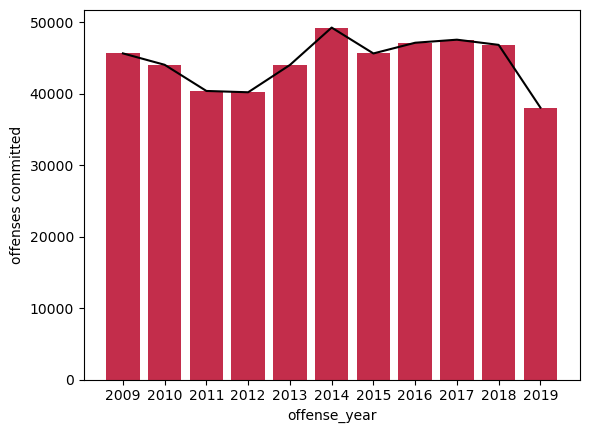

offense_year          1.826546e+42
offenses committed    4.445636e+04
dtype: float64

In [69]:
#plotting overall Seattle crime counts across the 2009-2019 years
sns.barplot(crime_year_counts, x='offense_year', y='offenses committed', color='crimson')
sns.lineplot(crime_year_counts, x='offense_year', y='offenses committed', color='black')
plt.show()

crime_year_counts.mean()

<Axes: xlabel='offense_year', ylabel='count'>

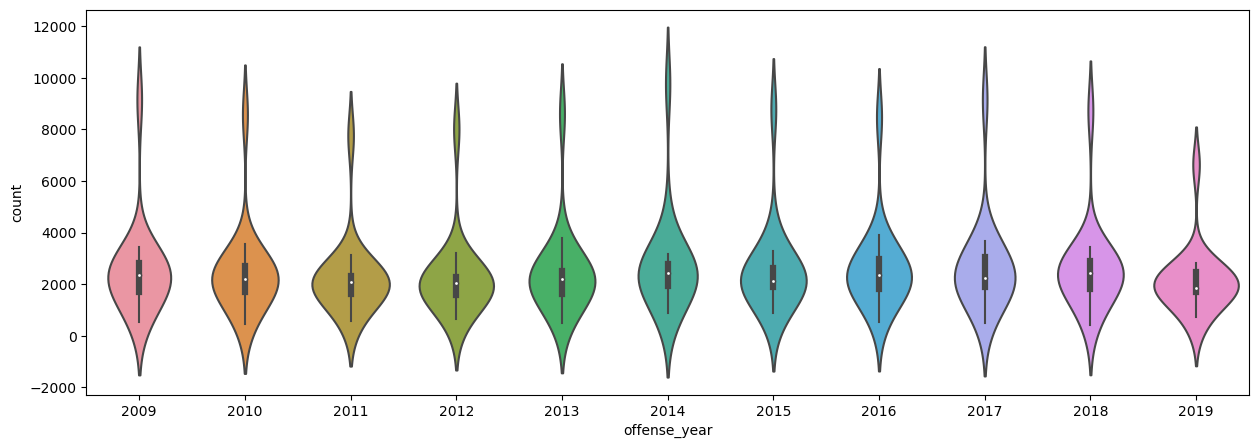

In [101]:
#plotting a violin plot to understand general distribution of data
plt.figure(figsize=(15,5))
sns.violinplot(data=crime_count_district, x='offense_year', y='count')

From this violin plot, we can see that the median values for each of the reported years follows a similar trend to the number of crimes reported. It is particularly interesting to see how much lower the median for 2019 is relative to the previous years. It is important to note that while a few of the median values are somewhat right in the middle, there are a few that edge much closer to the first quartile and the third quartile, demonstrating a skew. For the years where the median is closer to the first quartile, we see a negative skew, which aligns with a slight decrease in crime, and 'more' values that are smaller than the median itself. In the years we see the median inching closer to the third quartile, we observe longer tails, and can infer there are more values that are larger than the median in those years. 

We can also gather there are some constant outliers across the 10 years, but these are distinct in that they represent a subgroup in the data, which indicates the presence of at least 1 district that sees much higher crime counts in any given year. 

<Axes: xlabel='offense_year', ylabel='L_HOOD'>

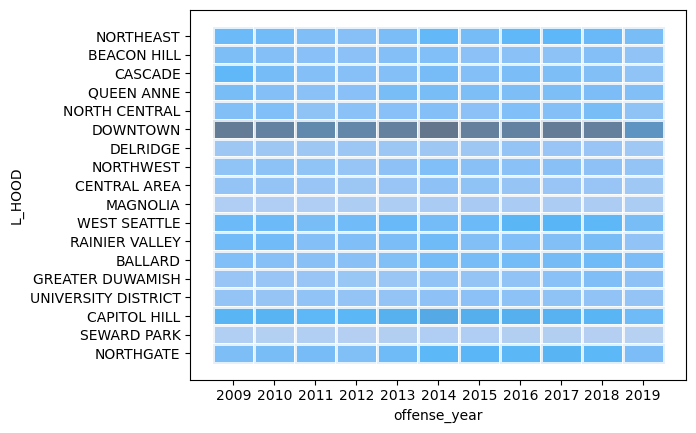

In [70]:
#plotting to visualize the highest/lowest crime counts per district across time
sns.histplot(data=crime_data_merge, x='offense_year', y='L_HOOD', stat='density', alpha = 0.8, edgecolor = 'white')

From this histplot, I can see crime isn't reported/doesn't occur in the same frequency across all districts. Downtown clearly has the highest concentration across the decade, and it seems Magnolia and Sward Park are somewhat tied for the lowest crime reporting. 

# Part 3: Questions & Insights
1. What districts have the highest and lowest crime reporting across the decade of interest?
2. Are these the same across all years?
3. Are the districts that report the median amount of each year the same across time? 

In [71]:
#sepatrating crime counts by district by year
crime_count_district = crime_data_merge.groupby(['offense_year', 'L_HOOD']).size().reset_index(name='count')
crime_count_district

,offense_year,L_HOOD,count
0,2009,BALLARD,2327
1,2009,BEACON HILL,2416
2,2009,CAPITOL HILL,3430
3,2009,CASCADE,3050
4,2009,CENTRAL AREA,1711
...,...,...,...
193,2019,QUEEN ANNE,2274
194,2019,RAINIER VALLEY,1792
195,2019,SEWARD PARK,298
196,2019,UNIVERSITY DISTRICT,1690


In [72]:
#sorting the values and adding a column to rank the number of offenses reported by year
crime_count_district_sorted = crime_count_district.sort_values(by=['offense_year', 'count'], ascending=[True,False])
#grouping by year once more
group_sorted = crime_count_district_sorted.groupby('offense_year')
#ranking with pandas method
crime_count_district_sorted['crime_rank'] = group_sorted['count'].rank(method='min', ascending=False)

crime_count_district_sorted.reset_index(drop=True, inplace=True)
#inspecting
crime_count_district_sorted    

,offense_year,L_HOOD,count,crime_rank
0,2009,DOWNTOWN,9145,1.0
1,2009,CAPITOL HILL,3430,2.0
2,2009,CASCADE,3050,3.0
3,2009,NORTHEAST,2852,4.0
4,2009,WEST SEATTLE,2825,5.0
...,...,...,...,...
193,2019,UNIVERSITY DISTRICT,1690,14.0
194,2019,DELRIDGE,1295,15.0
195,2019,CENTRAL AREA,1270,16.0
196,2019,MAGNOLIA,729,17.0


In [73]:
crime_count_district_sorted.describe()

,count,crime_rank
count,198.000000,198.000000
mean,2456.868687,9.500000
std,1669.350034,5.201279
min,298.000000,1.000000
25%,1706.250000,5.000000
50%,2198.000000,9.500000
75%,2670.000000,14.000000
max,9759.000000,18.000000


In [75]:
print(crime_count_district_sorted['crime_rank'].median())
print(crime_count_district_sorted['crime_rank'].max())

9.5
18.0


In [76]:
most_crime_district = crime_count_district_sorted.loc[crime_count_district_sorted['crime_rank'] == 1]
most_crime_district

#add percent increase-decrease column to add these labels to plot

,offense_year,L_HOOD,count,crime_rank
0,2009,DOWNTOWN,9145,1.0
18,2010,DOWNTOWN,8572,1.0
36,2011,DOWNTOWN,7762,1.0
54,2012,DOWNTOWN,8008,1.0
72,2013,DOWNTOWN,8601,1.0
90,2014,DOWNTOWN,9759,1.0
108,2015,DOWNTOWN,8778,1.0
126,2016,DOWNTOWN,8466,1.0
144,2017,DOWNTOWN,9140,1.0
162,2018,DOWNTOWN,8719,1.0


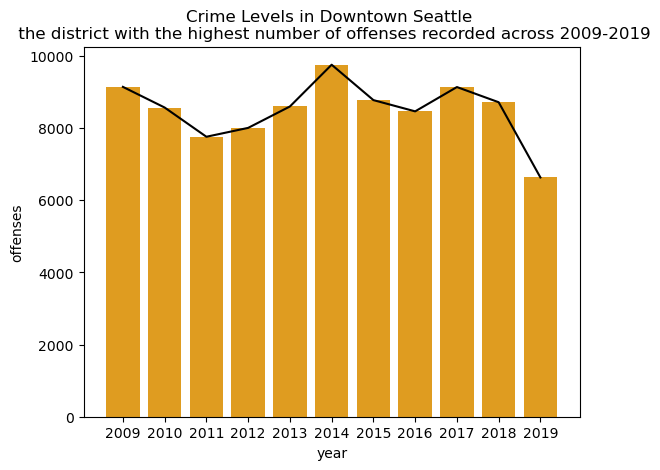

In [78]:
sns.barplot(data=most_crime_district, x='offense_year', y='count', color='orange').set(
title='Crime Levels in Downtown Seattle \n the district with the highest number of offenses recorded across 2009-2019',
xlabel = 'year', ylabel='offenses')
sns.lineplot(most_crime_district, x='offense_year', y='count', color='black')
plt.show()

In [79]:
least_crime_district = crime_count_district_sorted.loc[crime_count_district_sorted['crime_rank'] == 18]
least_crime_district

,offense_year,L_HOOD,count,crime_rank
17,2009,SEWARD PARK,536,18.0
35,2010,SEWARD PARK,467,18.0
53,2011,SEWARD PARK,534,18.0
71,2012,SEWARD PARK,456,18.0
89,2013,SEWARD PARK,505,18.0
107,2014,SEWARD PARK,604,18.0
125,2015,SEWARD PARK,597,18.0
143,2016,SEWARD PARK,526,18.0
161,2017,SEWARD PARK,505,18.0
179,2018,SEWARD PARK,422,18.0


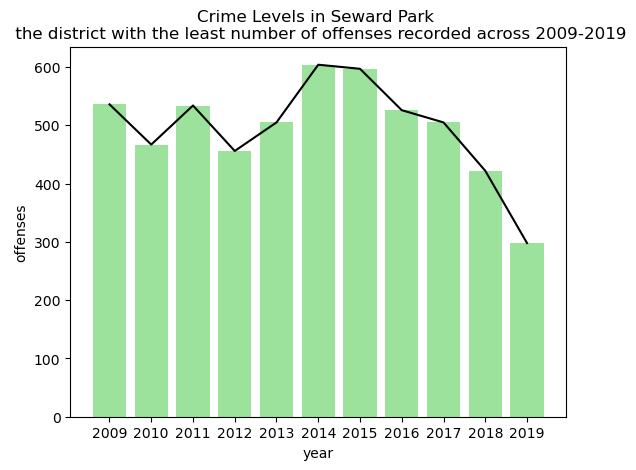

In [80]:
sns.barplot(data=least_crime_district, x='offense_year', y='count', color='lightgreen').set(
title='Crime Levels in Seward Park \n the district with the least number of offenses recorded across 2009-2019',
xlabel = 'year', ylabel='offenses')
sns.lineplot(data=least_crime_district, x='offense_year', y='count', color='black')
plt.show()

In [81]:
mid_crime_level = crime_count_district_sorted.loc[crime_count_district_sorted['crime_rank'] == 9]
mid_crime_level

,offense_year,L_HOOD,count,crime_rank
8,2009,BEACON HILL,2416,9.0
26,2010,BEACON HILL,2227,9.0
44,2011,BALLARD,2084,9.0
62,2012,BALLARD,2091,9.0
80,2013,BEACON HILL,2239,9.0
98,2014,QUEEN ANNE,2517,9.0
116,2015,CASCADE,2211,9.0
134,2016,NORTH CENTRAL,2347,9.0
152,2017,RAINIER VALLEY,2273,9.0
170,2018,QUEEN ANNE,2466,9.0


In [82]:
len(mid_crime_level['L_HOOD'].unique())

6

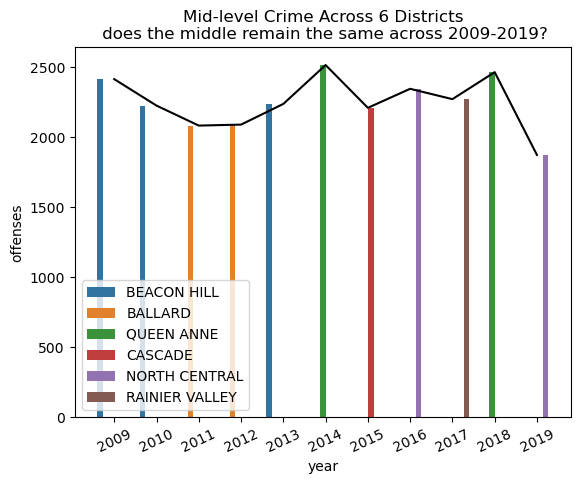

In [83]:
sns.barplot(data=mid_crime_level, x='offense_year', y='count', hue='L_HOOD').set(
title='Mid-level Crime Across 6 Districts\n does the middle remain the same across 2009-2019?',
xlabel = 'year', ylabel='offenses')
sns.lineplot(data=mid_crime_level, x='offense_year', y='count', color='black')
plt.xticks(rotation=25)
plt.show()

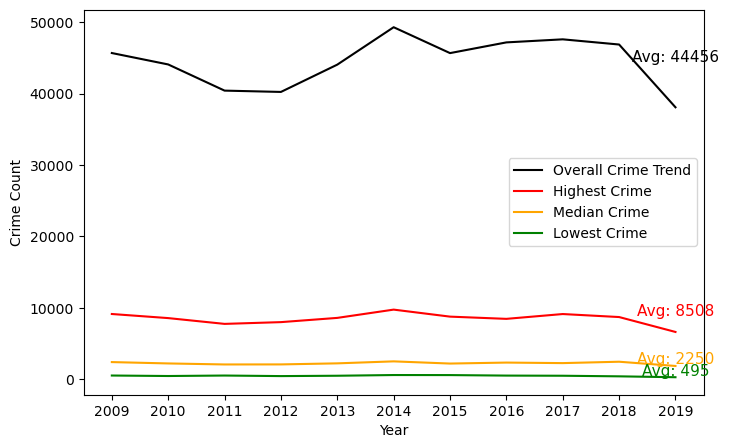

In [84]:
plt.figure(figsize=(8,5))

#plotting the different crime levels in one plot
sns.lineplot(crime_year_counts, x='offense_year', y='offenses committed', color='black', label='Overall Crime Trend')
sns.lineplot(most_crime_district, x='offense_year', y='count', color='red', label='Highest Crime')
sns.lineplot(data=mid_crime_level, x='offense_year', y='count', color='orange', label='Median Crime')
sns.lineplot(data=least_crime_district, x='offense_year', y='count', color='green', label='Lowest Crime')

plt.xlabel('Year')
plt.ylabel('Crime Count')

#plt.xticks()
overall_mean = crime_year_counts['offenses committed'].mean()
most_mean = most_crime_district['count'].mean()
mid_mean = mid_crime_level['count'].mean()
least_mean = least_crime_district['count'].mean()

#adding mean sticker text to each line
plt.text(crime_year_counts['offense_year'].iloc[-1], overall_mean, f'Avg: {overall_mean:.0f}', fontsize=11, va='baseline', ha='center', color='black')
plt.text(most_crime_district['offense_year'].iloc[-1], most_mean, f'Avg: {most_mean:.0f}', fontsize=11, va='bottom', ha='center', color='red')
plt.text(mid_crime_level['offense_year'].iloc[-1], mid_mean, f'Avg: {mid_mean:.0f}', fontsize=11, va='baseline', ha='center', color='orange')
plt.text(least_crime_district['offense_year'].iloc[-1], least_mean, f'Avg: {least_mean:.0f}', fontsize=11, va='baseline', ha='center', color='green')

plt.show()

## further downtown & seward park evaluation
knowing there are two specific districts that were consistently ranked highest and lowest, are the types of crime they experienced from 2009-2019 of one particular kind, or is this variable different? 

In [85]:
#filtering data to analyze downtown on its own specifically
downtown_crime = crime_data_merge.loc[crime_data_merge['L_HOOD'] == 'DOWNTOWN']

#finding all crime type categories in the data
downtown_crime_types = downtown_crime['crime_against_category'].unique()
print(downtown_crime_types)

#finding the number of types of crimes 
len(downtown_crime_types)


#noticed there is a 'NOT_A_CRIME' category, inspecting how many instances this occurs
no_crime = downtown_crime.loc[downtown_crime['crime_against_category'] == 'NOT_A_CRIME']
no_crime
#there are only 3 not_a_crime instances, which belong to the same offense parent group of homicides
#since these occur once in 3 different years, i'll exclude them from my analysis for now

#filtering for only 3 crime groups
downtown_3crime_groups = downtown_crime[downtown_crime['crime_against_category'].isin(['PROPERTY', 'SOCIETY', 'PERSON'])]

#creating grouping by crime type
prop_per_soc_dcrimes = downtown_3crime_groups.groupby('offense_year')['crime_against_category'].value_counts().reset_index(name='crime_type_count')
prop_per_soc_dcrimes

['PROPERTY' 'SOCIETY' 'PERSON' 'NOT_A_CRIME']


,offense_year,crime_against_category,crime_type_count
0,2009,PROPERTY,7494
1,2009,SOCIETY,1567
2,2009,PERSON,84
3,2010,PROPERTY,6777
4,2010,SOCIETY,1721
5,2010,PERSON,74
6,2011,PROPERTY,6272
7,2011,SOCIETY,1421
8,2011,PERSON,69
9,2012,PROPERTY,6560


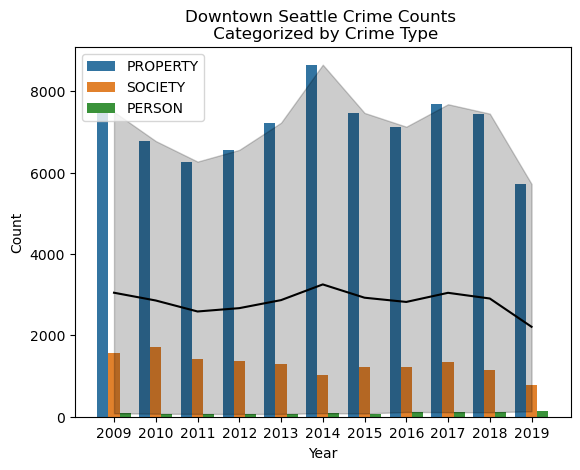

In [86]:
sns.barplot(data=prop_per_soc_dcrimes, x='offense_year', y='crime_type_count', hue='crime_against_category').set(
title='Downtown Seattle Crime Counts \n Categorized by Crime Type', xlabel='Year', ylabel='Count')
sns.lineplot(data=prop_per_soc_dcrimes, x='offense_year', y='crime_type_count', color='black')
plt.show()

Noticed there are not a lot of crimes commited against the 'person' category, decided to explore what the subgroups of that category are and visualize those. 

In [87]:
#might not need this
person_crime = downtown_crime.loc[downtown_crime['crime_against_category'] == 'PERSON']
person_crime_subgroups = person_crime.groupby('offense_year')['offense_parent_group'].value_counts().reset_index(name='person_subgroups_count')
person_crime_subgroups

,offense_year,offense_parent_group,person_subgroups_count
0,2009,SEX OFFENSES,76
1,2009,KIDNAPPING/ABDUCTION,5
2,2009,HOMICIDE OFFENSES,3
3,2010,SEX OFFENSES,60
4,2010,HOMICIDE OFFENSES,7
5,2010,KIDNAPPING/ABDUCTION,6
6,2010,"SEX OFFENSES, CONSENSUAL",1
7,2011,SEX OFFENSES,60
8,2011,KIDNAPPING/ABDUCTION,7
9,2011,HOMICIDE OFFENSES,2


In [88]:
#calculating probability of person, society, and property crimes happening based on overall downtown crime pop
prop_per_soc_dcrimes['probability_type_crime'] = (prop_per_soc_dcrimes['crime_type_count']/(prop_per_soc_dcrimes.groupby('offense_year')['crime_type_count'].transform('sum')))*100
prop_per_soc_dcrimes

,offense_year,crime_against_category,crime_type_count,probability_type_crime
0,2009,PROPERTY,7494,81.946419
1,2009,SOCIETY,1567,17.135046
2,2009,PERSON,84,0.918535
3,2010,PROPERTY,6777,79.059729
4,2010,SOCIETY,1721,20.076995
5,2010,PERSON,74,0.863276
6,2011,PROPERTY,6272,80.803917
7,2011,SOCIETY,1421,18.307137
8,2011,PERSON,69,0.888946
9,2012,PROPERTY,6560,81.918082


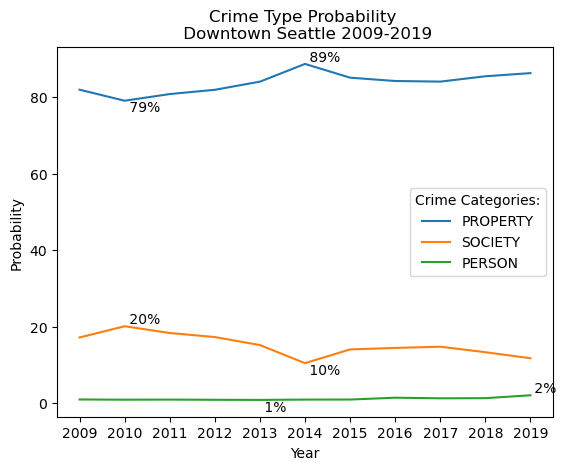

In [89]:
percent_line = sns.lineplot(data=prop_per_soc_dcrimes, x='offense_year', y='probability_type_crime', hue='crime_against_category')
percent_line.set(title='Crime Type Probability \n Downtown Seattle 2009-2019', xlabel='Year', ylabel='Probability')

for line in percent_line.lines:
    y_data = line.get_ydata()
    if len(y_data) > 0:
        max_percent = line.get_ydata().max()
        min_percent = line.get_ydata().min()
        max_index = line.get_ydata().argmax()
        min_index = line.get_ydata().argmin()
        percent_line.text(line.get_xdata()[max_index], max_percent, f'{max_percent: .0f}%', va='bottom')
        percent_line.text(line.get_xdata()[min_index], min_percent, f'{min_percent: .0f}%', va='top')

percent_line.legend(title='Crime Categories:')
plt.show()

In [90]:
#seward park work
#filtering data to analyze downtown on its own specifically
seward_crime = crime_data_merge.loc[crime_data_merge['L_HOOD'] == 'SEWARD PARK']

#finding all crime type categories in the data
seward_crime_types = seward_crime['crime_against_category'].unique()
print(seward_crime_types)

#finding the number of types of crimes 
len(seward_crime_types)

#creating grouping by crime type
sp_crimes = seward_crime.groupby('offense_year')['crime_against_category'].value_counts().reset_index(name='crime_type_count')
sp_crimes

#calculating probability of person, society, and property crimes happening based on overall seward park crime pop
sp_crimes['probability_type_crime'] = (sp_crimes['crime_type_count']/(sp_crimes.groupby('offense_year')['crime_type_count'].transform('sum')))*100
sp_crimes

['PROPERTY' 'SOCIETY' 'PERSON']


,offense_year,crime_against_category,crime_type_count,probability_type_crime
0,2009,PROPERTY,460,85.820896
1,2009,SOCIETY,71,13.246269
2,2009,PERSON,5,0.932836
3,2010,PROPERTY,402,86.081370
4,2010,SOCIETY,61,13.062099
5,2010,PERSON,4,0.856531
6,2011,PROPERTY,485,90.823970
7,2011,SOCIETY,45,8.426966
8,2011,PERSON,4,0.749064
9,2012,PROPERTY,407,89.254386


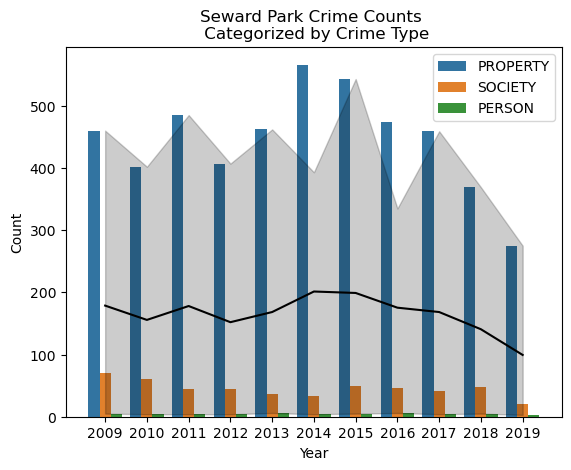

In [91]:
#visualizing crime in seward park
sns.barplot(data=sp_crimes, x='offense_year', y='crime_type_count', hue='crime_against_category').set(
title='Seward Park Crime Counts \n Categorized by Crime Type', xlabel='Year', ylabel='Count')
sns.lineplot(data=sp_crimes, x='offense_year', y='crime_type_count', color='black')
plt.show()

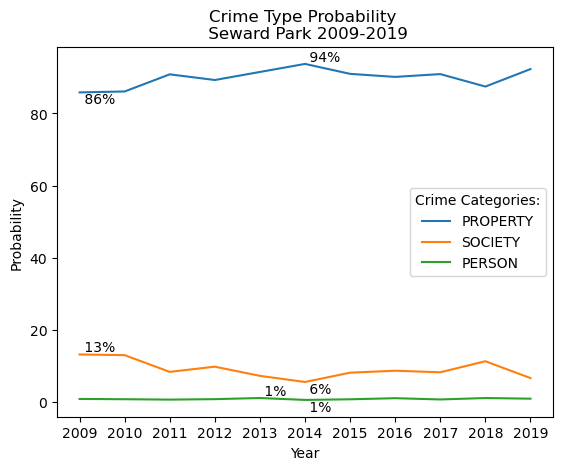

In [92]:
percent_line = sns.lineplot(data=sp_crimes, x='offense_year', y='probability_type_crime', hue='crime_against_category')
percent_line.set(title='Crime Type Probability \n Seward Park 2009-2019', xlabel='Year', ylabel='Probability')

def add_min_max_percent(graph):
    for line in graph.lines:
        y_data = line.get_ydata()
        if len(y_data) > 0:
            max_percent = line.get_ydata().max()
            min_percent = line.get_ydata().min()
            max_index = line.get_ydata().argmax()
            min_index = line.get_ydata().argmin()
            percent_line.text(line.get_xdata()[max_index], max_percent, f'{max_percent: .0f}%', va='bottom')
            percent_line.text(line.get_xdata()[min_index], min_percent, f'{min_percent: .0f}%', va='top')

add_min_max_percent(percent_line)
            
percent_line.legend(title='Crime Categories:')
plt.show()

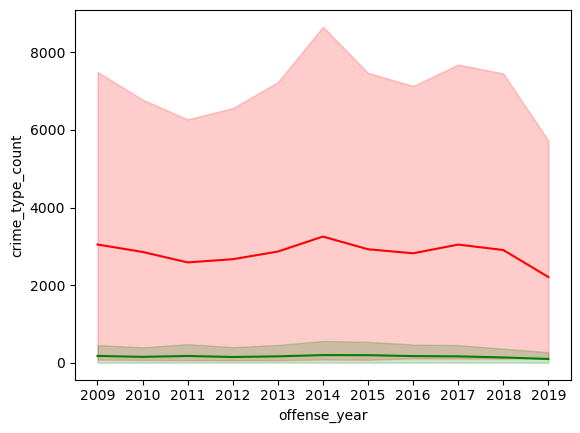

In [93]:
#comparing line trends for seward park and downtown
sns.lineplot(data=prop_per_soc_dcrimes, x='offense_year', y='crime_type_count', color='red')
sns.lineplot(data=sp_crimes, x='offense_year', y='crime_type_count', color='green')
plt.show()

In [94]:
#calculate probability of specific crime type happening for mid-level crime districts separately
mid_crime_districts = mid_crime_level['L_HOOD'].unique()
mid_crime_districts = mid_crime_districts.tolist()
mid_crime_districts

['BEACON HILL',
 'BALLARD',
 'QUEEN ANNE',
 'CASCADE',
 'NORTH CENTRAL',
 'RAINIER VALLEY']

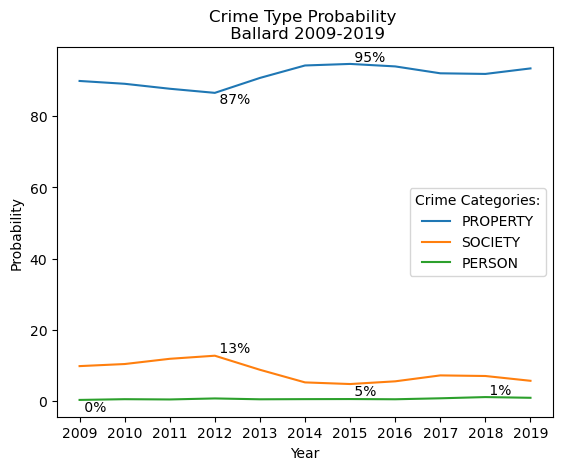

In [95]:
#function to do the specific crime type probability calculations with respect to a specific district and year's crime count
def mid_crime_calculations(data, district):
    district_crime = data.loc[data['L_HOOD'] == district]
    district_crime_filtered = district_crime[district_crime['crime_against_category'].isin(['PROPERTY', 'SOCIETY', 'PERSON'])]
    district_crime_groups = district_crime_filtered.groupby('offense_year')['crime_against_category'].value_counts().reset_index(name='crime_type_count')
    district_crime_groups['probability_type_crime'] = (district_crime_groups['crime_type_count']/(district_crime_groups.groupby('offense_year')['crime_type_count'].transform('sum')))*100
    return district_crime_groups
 
ballard_crime = mid_crime_calculations(crime_data_merge, 'BALLARD')

percent_line = sns.lineplot(data=ballard_crime, x='offense_year', y='probability_type_crime', hue='crime_against_category')
percent_line.set(title='Crime Type Probability \n Ballard 2009-2019', xlabel='Year', ylabel='Probability')

add_min_max_percent(percent_line)

percent_line.legend(title='Crime Categories:')
plt.show()

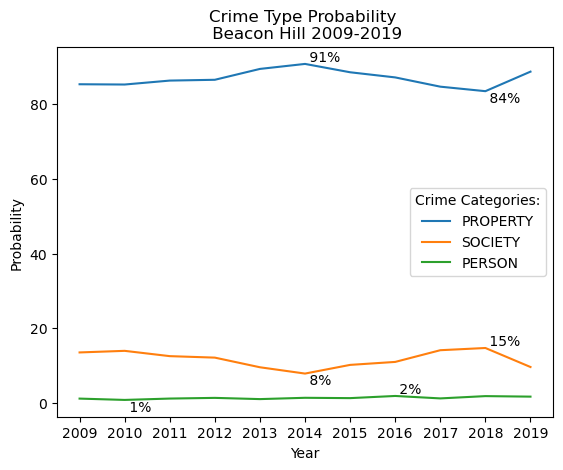

In [96]:
beacon_hill_crime = mid_crime_calculations(crime_data_merge, 'BEACON HILL')

percent_line = sns.lineplot(data=beacon_hill_crime, x='offense_year', y='probability_type_crime', hue='crime_against_category')
percent_line.set(title='Crime Type Probability \n Beacon Hill 2009-2019', xlabel='Year', ylabel='Probability')

add_min_max_percent(percent_line)

percent_line.legend(title='Crime Categories:')
plt.show()

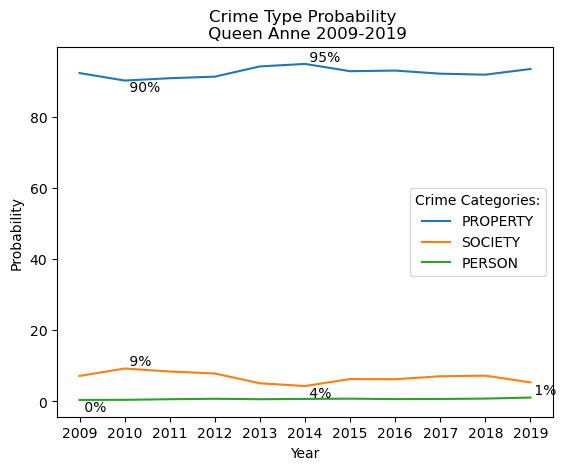

In [97]:
queen_anne_crime = mid_crime_calculations(crime_data_merge, 'QUEEN ANNE')

percent_line = sns.lineplot(data=queen_anne_crime, x='offense_year', y='probability_type_crime', hue='crime_against_category')
percent_line.set(title='Crime Type Probability \n Queen Anne 2009-2019', xlabel='Year', ylabel='Probability')

add_min_max_percent(percent_line)

percent_line.legend(title='Crime Categories:')
plt.show()

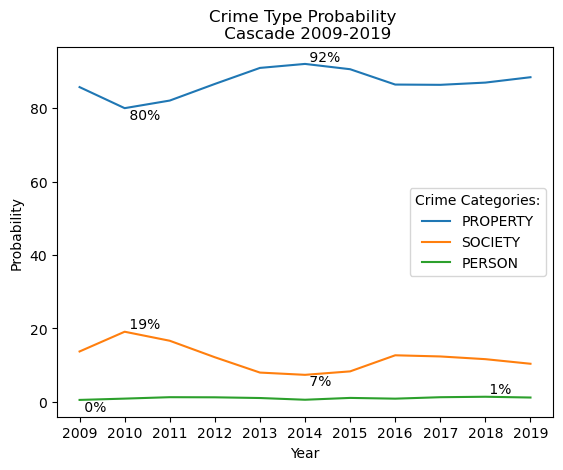

In [98]:
cascade_crime = mid_crime_calculations(crime_data_merge, 'CASCADE')

percent_line = sns.lineplot(data=cascade_crime, x='offense_year', y='probability_type_crime', hue='crime_against_category')
percent_line.set(title='Crime Type Probability \n Cascade 2009-2019', xlabel='Year', ylabel='Probability')

add_min_max_percent(percent_line)

percent_line.legend(title='Crime Categories:')
plt.show()

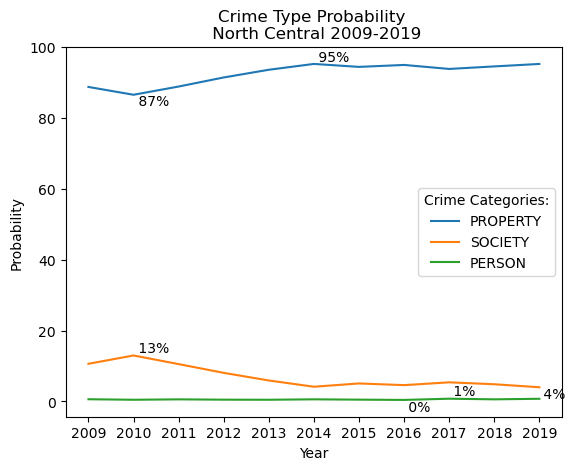

In [99]:
ncentral_crime = mid_crime_calculations(crime_data_merge, 'NORTH CENTRAL')

percent_line = sns.lineplot(data=ncentral_crime, x='offense_year', y='probability_type_crime', hue='crime_against_category')
percent_line.set(title='Crime Type Probability \n North Central 2009-2019', xlabel='Year', ylabel='Probability')

add_min_max_percent(percent_line)

percent_line.legend(title='Crime Categories:')
plt.show()

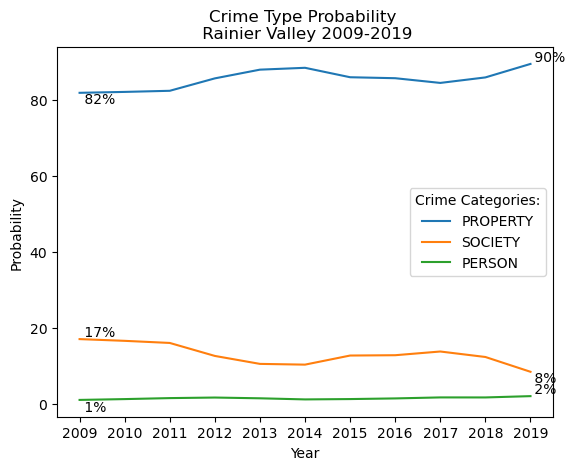

In [100]:
rainier_valley_crime = mid_crime_calculations(crime_data_merge, 'RAINIER VALLEY')

percent_line = sns.lineplot(data=rainier_valley_crime, x='offense_year', y='probability_type_crime', hue='crime_against_category')
percent_line.set(title='Crime Type Probability \n Rainier Valley 2009-2019', xlabel='Year', ylabel='Probability')

add_min_max_percent(percent_line)

percent_line.legend(title='Crime Categories:')
plt.show()

## Comparing crime & probability of experiencing crime relative to Seattle's population

In [102]:
#loading new dataframe with seattle population numbers
#source: <a href='https://www.macrotrends.net/cities/23140/seattle/population'>Source</a>
historical_seattle_population = pd.read_csv('Seattle-population-2024-02-07.csv')
historical_seattle_population['Year'] = historical_seattle_population['date'].str.slice(stop=4)

In [103]:
#filtering data for years of interest
seattle_pop = historical_seattle_population.loc[(historical_seattle_population['Year'] >= '2009') & (historical_seattle_population['Year'] <= '2019')]
seattle_pop

,date,Population,Annual Change,Year
59,2009-12-31,3032000,1.20,2009
60,2010-12-31,3069000,1.22,2010
61,2011-12-31,3106000,1.21,2011
62,2012-12-31,3143000,1.19,2012
63,2013-12-31,3182000,1.24,2013
64,2014-12-31,3220000,1.19,2014
65,2015-12-31,3259000,1.21,2015
66,2016-12-31,3299000,1.23,2016
67,2017-12-31,3339000,1.21,2017
68,2018-12-31,3379000,1.20,2018


In [104]:
#merging the crime counts with new population data to do probability calculations
pop_crime_counts = pd.merge(crime_year_counts, seattle_pop, left_on= 'offense_year', right_on='Year', how='left')
pop_crime_counts

,offense_year,offenses committed,date,Population,Annual Change,Year
0,2009,45667,2009-12-31,3032000,1.20,2009
1,2010,44069,2010-12-31,3069000,1.22,2010
2,2011,40407,2011-12-31,3106000,1.21,2011
3,2012,40223,2012-12-31,3143000,1.19,2012
4,2013,44044,2013-12-31,3182000,1.24,2013
5,2014,49279,2014-12-31,3220000,1.19,2014
6,2015,45657,2015-12-31,3259000,1.21,2015
7,2016,47156,2016-12-31,3299000,1.23,2016
8,2017,47584,2017-12-31,3339000,1.21,2017
9,2018,46858,2018-12-31,3379000,1.20,2018


In [105]:
pop_crime_counts.columns

Index(['offense_year', 'offenses committed', 'date', ' Population',
       ' Annual Change', 'Year'],
      dtype='object')

Given the metro population, what is the probability any individual would have of experiencing any kind of crime first hand?

In [106]:
#calculating probability of experiencing crime first hand per year in data
for i, row in pop_crime_counts.iterrows():
    population = row[' Population']
    crimes = row['offenses committed']
    individual_probability = round((crimes/population)*100, 1)
    
    pop_crime_counts.loc[i,'probability_experiencing_crime'] = individual_probability

pop_crime_counts

,offense_year,offenses committed,date,Population,Annual Change,Year,probability_experiencing_crime
0,2009,45667,2009-12-31,3032000,1.20,2009,1.5
1,2010,44069,2010-12-31,3069000,1.22,2010,1.4
2,2011,40407,2011-12-31,3106000,1.21,2011,1.3
3,2012,40223,2012-12-31,3143000,1.19,2012,1.3
4,2013,44044,2013-12-31,3182000,1.24,2013,1.4
5,2014,49279,2014-12-31,3220000,1.19,2014,1.5
6,2015,45657,2015-12-31,3259000,1.21,2015,1.4
7,2016,47156,2016-12-31,3299000,1.23,2016,1.4
8,2017,47584,2017-12-31,3339000,1.21,2017,1.4
9,2018,46858,2018-12-31,3379000,1.20,2018,1.4


In [107]:
pop_crime_counts['probability_experiencing_crime'].max()

1.5

In [108]:
pop_crime_counts['probability_experiencing_crime'].min()

1.1

An individual's probability of experiencing any type of crime first hand is extremely low, ranging from 1.1-1.5%. 

In [110]:
#normalizing data with sklearn
pop_column_array = np.array(pop_crime_counts[' Population']).reshape(-1,1)
crimecount_column_array = np.array(pop_crime_counts['offenses committed']).reshape(-1,1)

normalized_pop = preprocessing.normalize(pop_column_array, axis=0)
normalized_offenses = preprocessing.normalize(crimecount_column_array, axis=0)

#calculating crime rate
crime_rate = normalized_offenses/normalized_pop

#creating a DF with normalized values
normalized_values = pd.DataFrame({'Normalized Pop': normalized_pop.flatten(), 
                    'Normalized Offenses': normalized_offenses.flatten(), 'Crime Rate': crime_rate.flatten()})

pop_crime_counts_normalized = pd.concat([pop_crime_counts, normalized_values], axis=1)
pop_crime_counts_normalized

,offense_year,offenses committed,date,Population,Annual Change,Year,probability_experiencing_crime,Normalized Pop,Normalized Offenses,Crime Rate
0,2009,45667,2009-12-31,3032000,1.20,2009,1.5,0.283596,0.308840,1.089013
1,2010,44069,2010-12-31,3069000,1.22,2010,1.4,0.287057,0.298033,1.038236
2,2011,40407,2011-12-31,3106000,1.21,2011,1.3,0.290518,0.273267,0.940622
3,2012,40223,2012-12-31,3143000,1.19,2012,1.3,0.293979,0.272023,0.925316
4,2013,44044,2013-12-31,3182000,1.24,2013,1.4,0.297627,0.297864,1.000798
5,2014,49279,2014-12-31,3220000,1.19,2014,1.5,0.301181,0.333268,1.106537
6,2015,45657,2015-12-31,3259000,1.21,2015,1.4,0.304829,0.308772,1.012938
7,2016,47156,2016-12-31,3299000,1.23,2016,1.4,0.308570,0.318910,1.033509
8,2017,47584,2017-12-31,3339000,1.21,2017,1.4,0.312311,0.321805,1.030396
9,2018,46858,2018-12-31,3379000,1.20,2018,1.4,0.316053,0.316895,1.002664


Text(0.5, 1.0, 'Population vs Crime Over Time')

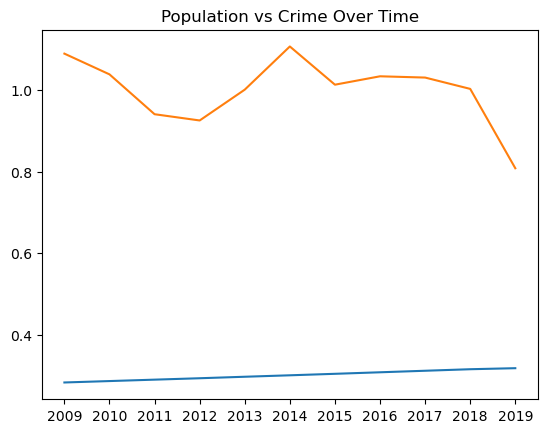

In [111]:
plt.figure()
plt.plot(pop_crime_counts['offense_year'], normalized_values['Normalized Pop'], label='Normalized Population')
plt.plot(pop_crime_counts['offense_year'], normalized_values['Crime Rate'], label='Crime Rate')
plt.title('Population vs Crime Over Time')

After normalizing the population and crime count values, I decided to plot these to see what their respective lines look like and determine whether population increases affect the crime rate. The population increases are relatively linear, which aligns with the plot, and we can see that despite the incremental upward trend, the crime rate is wholly unaffected by this. 

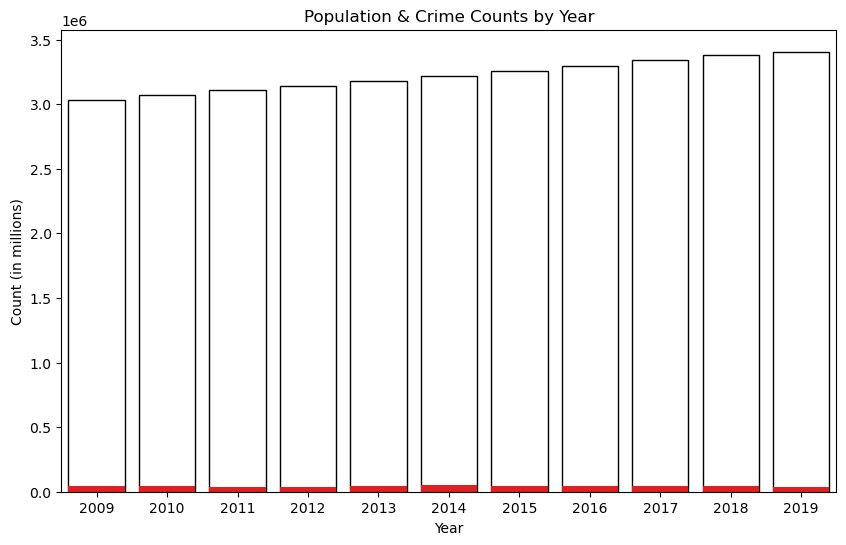

In [117]:
plt.figure(figsize=(10,6))
sns.barplot(data=pop_crime_counts, x='Year', y=' Population', label='Metro Population', fill=False)
sns.barplot(data=pop_crime_counts, x='Year', y='offenses committed', color = 'red', label='Crimes Committed Each Year')
plt.title('Population & Crime Counts by Year')
plt.xlabel('Year')
plt.ylabel('Count (in millions)')

#sns.lineplot(data=pop_crime_counts, x='offense_year', y='probability_experiencing_crime', color='red', marker='s')
#plt.ylabel('Individual Probability of Experiencing Crime')

plt.show()

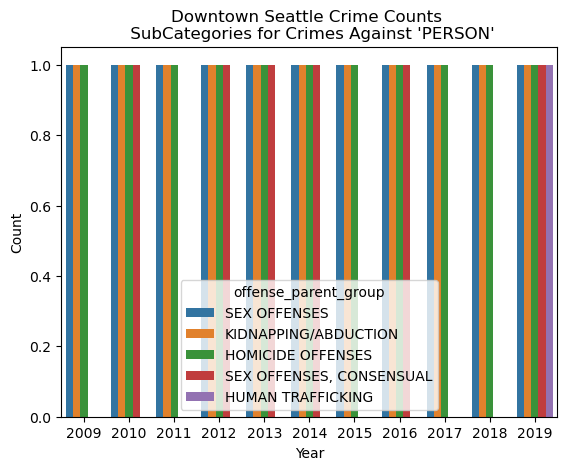

In [783]:
#might not use this

sns.countplot(data=person_crime_subgroups, x='offense_year', hue='offense_parent_group').set(
title='Downtown Seattle Crime Counts \n SubCategories for Crimes Against \'PERSON\'', xlabel='Year', ylabel='Count')
plt.show()